### **Notebook 02: ROI Generation and Analysis**

This notebook operationalizes the second stage of the analysis pipeline. The objective is to convert raw fixation locations from the CAT2000 `.mat` files into a structured set of spatially coherent Regions of Interest (ROIs). The ROIs act as data-driven proxies for scene areas that attracted sustained attention, moving from continuous fixation fields to discrete, quantifiable attentional targets.

The pipeline first performs a visual audit of the raw data, generates ROIs using a density-based clustering algorithm (DBSCAN), and concludes with statistical and visual validation of the resulting ROIs.

---

### **Section 0: Setup and Configuration**

In [4]:
# --- Section 0: Setup and Configuration ---

# Standard libs
import os
import sys
import random
from pathlib import Path
from typing import List, Tuple, Dict, Tuple, Any, Optional, Iterable

# Third-party
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from PIL import Image
from joblib import Parallel, delayed
from shapely.geometry import box, MultiPolygon, Polygon
from shapely.ops import unary_union
from sklearn.cluster import DBSCAN
from IPython.display import display
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Project config (assumes ../src/config.py)
sys.path.insert(0, str(Path("../src").resolve()))
import config

NOTEBOOK_NUM = 2  # used for standardized output paths

# ---------------------- Utilities ----------------------

def get_output_path(section_num: int, filename: str) -> Path:
    """Standardized output path for notebook artifacts."""
    out = config.RESULTS_DIR / f"notebook{NOTEBOOK_NUM:02d}" / f"section{section_num:02d}"
    out.mkdir(parents=True, exist_ok=True)
    return out / filename

def enforce_category_order(df: pd.DataFrame, col: str = "category") -> pd.DataFrame:
    """Cast df[col] to canonical ordered categories and return a sorted copy."""
    if col in df.columns:
        dtype = CategoricalDtype(categories=list(config.CATEGORY_ORDER), ordered=True)
        out = df.copy()
        out[col] = out[col].astype(dtype)
        return out.sort_values(col)
    return df

def save_dataframe_as_markdown(df: pd.DataFrame, filepath: Path, title: str = "") -> None:
    """Write a DataFrame to Markdown with consistent numeric formatting."""
    df_to_write = df.copy()

    def _fmt_float(x: float) -> str:
        if pd.isna(x): return ""
        if 0 < abs(x) < 0.001:
            return f"{x:.2e}"
        return f"{x:.3f}"

    df_fmt = df_to_write.copy()
    for col in df_fmt.select_dtypes(include=[float]).columns:
        df_fmt[col] = df_fmt[col].map(_fmt_float)

    with open(filepath, "w", encoding="utf-8") as f:
        if title:
            f.write(f"## {title}\n\n")
        f.write(df_fmt.to_markdown(index=False))
    print(f"[saved] {filepath}")

# ------------------ Fixation loading ------------------

def _load_fixation_mat_robust(mat_path: Path) -> Tuple[np.ndarray, int, int]:
    """
    Canonical loader: returns (fixation_map HxW int32, total_fixations, n_oob).
    Accepts either:
      - precomputed HxW fixation map, or
      - Nx2 / 2xN coordinate arrays (auto-detects 1-based vs 0-based).
    """
    H, W = int(config.IMG_HEIGHT), int(config.IMG_WIDTH)
    if not mat_path.exists():
        raise FileNotFoundError(f"Missing fixation file: {mat_path}")

    m = scipy.io.loadmat(mat_path)
    # Common key variants seen in CAT2000 style dumps
    keys = ("fixLocs", "gnd", "fixLocsXY", "fixLocs_XY", "fixations", "map", "fixmap", "fixation_map")
    arr = next((np.asarray(m[k]) for k in keys if k in m), None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Unknown or empty fixation format in {mat_path.name}")

    # Case A - precomputed raster map
    if arr.ndim == 2 and arr.shape == (H, W):
        fm = np.rint(np.clip(arr, a_min=0, a_max=None)).astype(np.int32)
        return fm, int(fm.sum()), 0

    # Case B - coordinates -> rasterize
    if arr.ndim == 2:
        coords = arr if arr.shape[1] == 2 else arr.T
        if coords.shape[1] != 2:
            raise ValueError(f"Fixation coords must be Nx2 or 2xN in {mat_path.name}")
        x_raw = coords[:, 0].astype(float)
        y_raw = coords[:, 1].astype(float)
        total = int(coords.shape[0])
        # Heuristic for 1-based data
        one_based = (x_raw.min() >= 1) and (y_raw.min() >= 1) and (x_raw.max() <= W) and (y_raw.max() <= H)
        if one_based:
            x_raw = x_raw - 1.0
            y_raw = y_raw - 1.0
        x = np.rint(x_raw).astype(np.int64)
        y = np.rint(y_raw).astype(np.int64)
        oob_mask = (x < 0) | (x >= W) | (y < 0) | (y >= H)
        n_oob = int(oob_mask.sum())
        xs = np.clip(x, 0, W - 1).astype(np.int32)
        ys = np.clip(y, 0, H - 1).astype(np.int32)
        fm = np.zeros((H, W), dtype=np.int32)
        np.add.at(fm, (ys, xs), 1)
        return fm, total, n_oob

    raise ValueError(f"Unhandled fixation array shape {arr.shape} in {mat_path.name}")

# Simple array-only adapter for existing call sites in this notebook
def _load_fixation_mat(mat_path: Path) -> np.ndarray:
    fm, _, _ = _load_fixation_mat_robust(mat_path)
    return fm

def _coords_from_mat(mat_path: Path) -> np.ndarray:
    """Return integer pixel coordinates (x, y) from the rasterized fixation map."""
    fm, _, _ = _load_fixation_mat_robust(mat_path)
    ys, xs = np.nonzero(fm)
    return np.column_stack((xs.astype(np.int64), ys.astype(np.int64)))

def _weights_for_dbscan(mat_path: Path, coords: np.ndarray) -> np.ndarray:
    """Return per-point weights from the raster map, or ones if empty."""
    fm, _, _ = _load_fixation_mat_robust(mat_path)
    if fm.sum() > 0 and coords.size > 0:
        return fm[coords[:, 1], coords[:, 0]]
    return np.ones(len(coords), dtype=np.float32)

# ---------------------- Environment ----------------------

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

palette = [config.CATEGORY_COLORS[c] for c in config.CATEGORY_ORDER]
sns.set_theme(style="whitegrid", palette=palette)

random.seed(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)

# --- Configuration Snapshot ---
print("[config] Project configuration")
for k, v in sorted({k: v for k, v in config.__dict__.items() if k.isupper() and not k.startswith("_")}.items()):
    print(f"{k:<22}: {v}")
    
print("[ok] Setup complete.\n")

[config] Project configuration
ANTHROPOMORPHIC_CATEGORIES: ['Action', 'Affective', 'Social']
BOXPLOT_WIDTH         : 0.45
CAT2000_DIR           : /home/nico/Projects/final_project/data/CAT2000/trainSet
CATEGORIES            : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CATEGORY_COLORS       : {'Action': '#7ad151', 'Affective': '#414487', 'Social': '#fde725', 'Indoor': '#22a884', 'OutdoorManMade': '#2a7886', 'OutdoorNatural': '#440154'}
CATEGORY_ORDER        : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CATEGORY_PALETTE      : ['#7ad151', '#414487', '#fde725', '#22a884', '#2a7886', '#440154']
CAT_ORDER             : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CENTER_BIAS_SIGMA_X_FRAC: 0.3
CENTER_BIAS_SIGMA_Y_FRAC: 0.3
DATA_DIR              : /home/nico/Projects/final_project/data
DBSCAN_EPS            : 60
DBSCAN_MIN_SAMPLES    : 15
DEFAULT_DECIMALS      : 3
FIG_DPI               

---

### **Section 1: Visual Inspection of Raw Fixation Data**

**Objective**

To inspect the unprocessed fixation data prior to any clustering or refinement. This provides a qualitative baseline and acts as a sanity check that the raw `.mat` files are being read and interpreted correctly.

**Rationale**

Before analysis, it is necessary to visually confirm that the raw fixation coordinates aligns with both the stimulus images and their corresponding pre-rendered density maps. This step helps identify any systematic issues in data loading, coordinate systems, or file correspondence early in the pipeline.

**Methodology**

One random stimulus was deterministically sampled from each of the six canonical categories using the global project seed. For each selected stimulus, a three-panel figure was produced:

1.  The original stimulus image (`.jpg`).
2.  The pre-rendered grayscale fixation density map supplied in CAT2000 (`.jpg`).
3.  The original image overlaid with the raw fixation coordinates from the corresponding `.mat` file, plotted as semi-transparent red points.

**Inputs**

*   `config.STIMULI_DIR`: Path to the directory containing stimulus images.
*   `config.FIXATIONLOCS_DIR`: Path to the directory containing `.mat` fixation files.
*   `config.FIXATIONMAPS_DIR`: Path to the directory containing pre-rendered fixation map images.

**Outputs**

*   `results/notebook02/section01/fig_inspection_{category}_{stem}.png`: Per-category sample visualization.
*   `results/notebook02/section01/fig_inspection_{category}_{stem}.svg`: Vector graphics version of the visualization.

[step] Visual inspection of raw fixation data
[info] Action/017: overlaying 332 unique fixation points


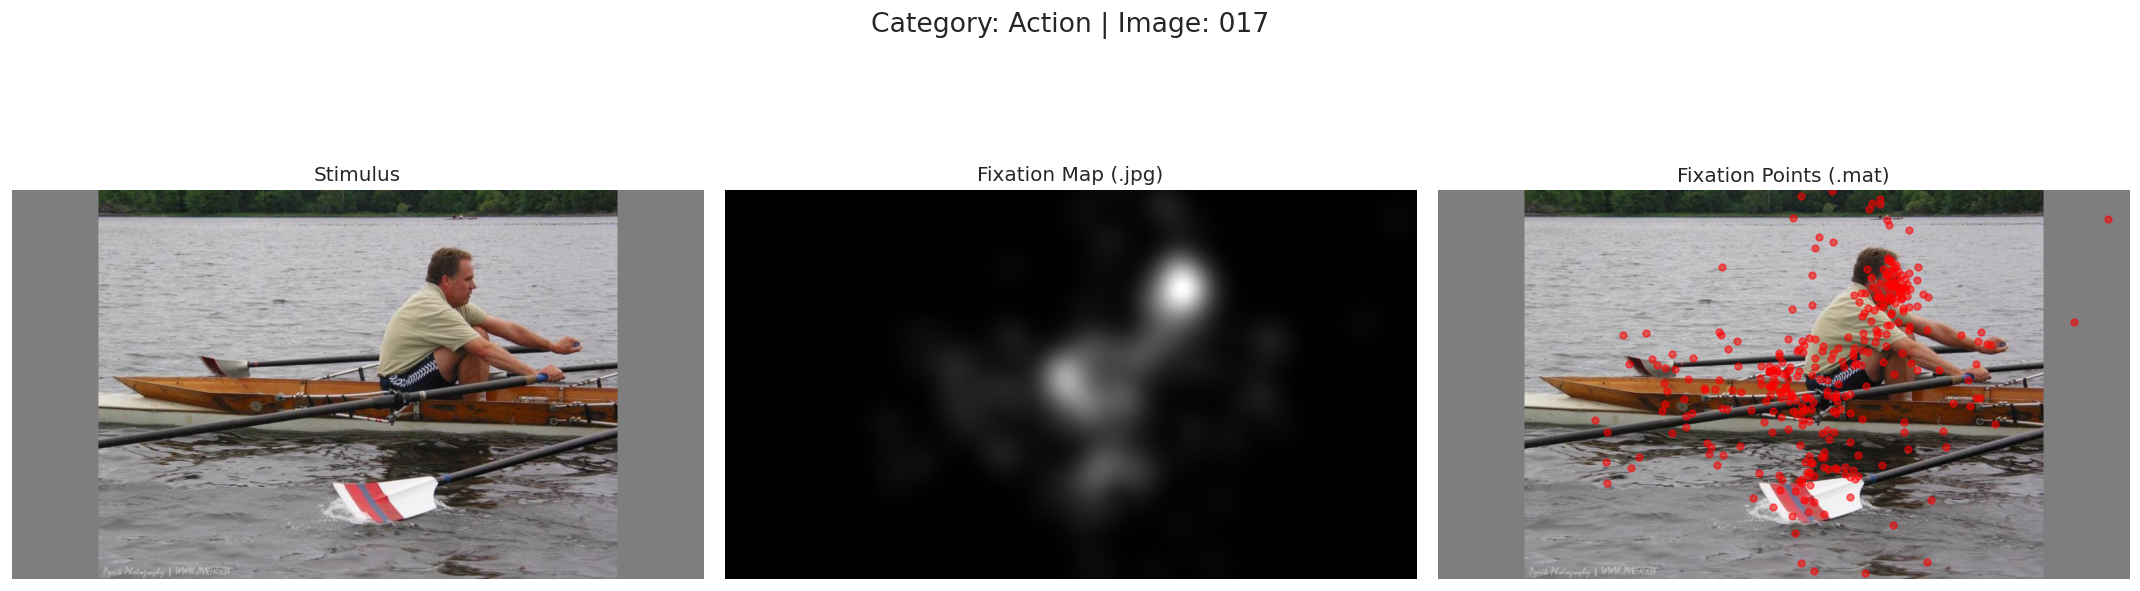

[info] Affective/155: overlaying 415 unique fixation points


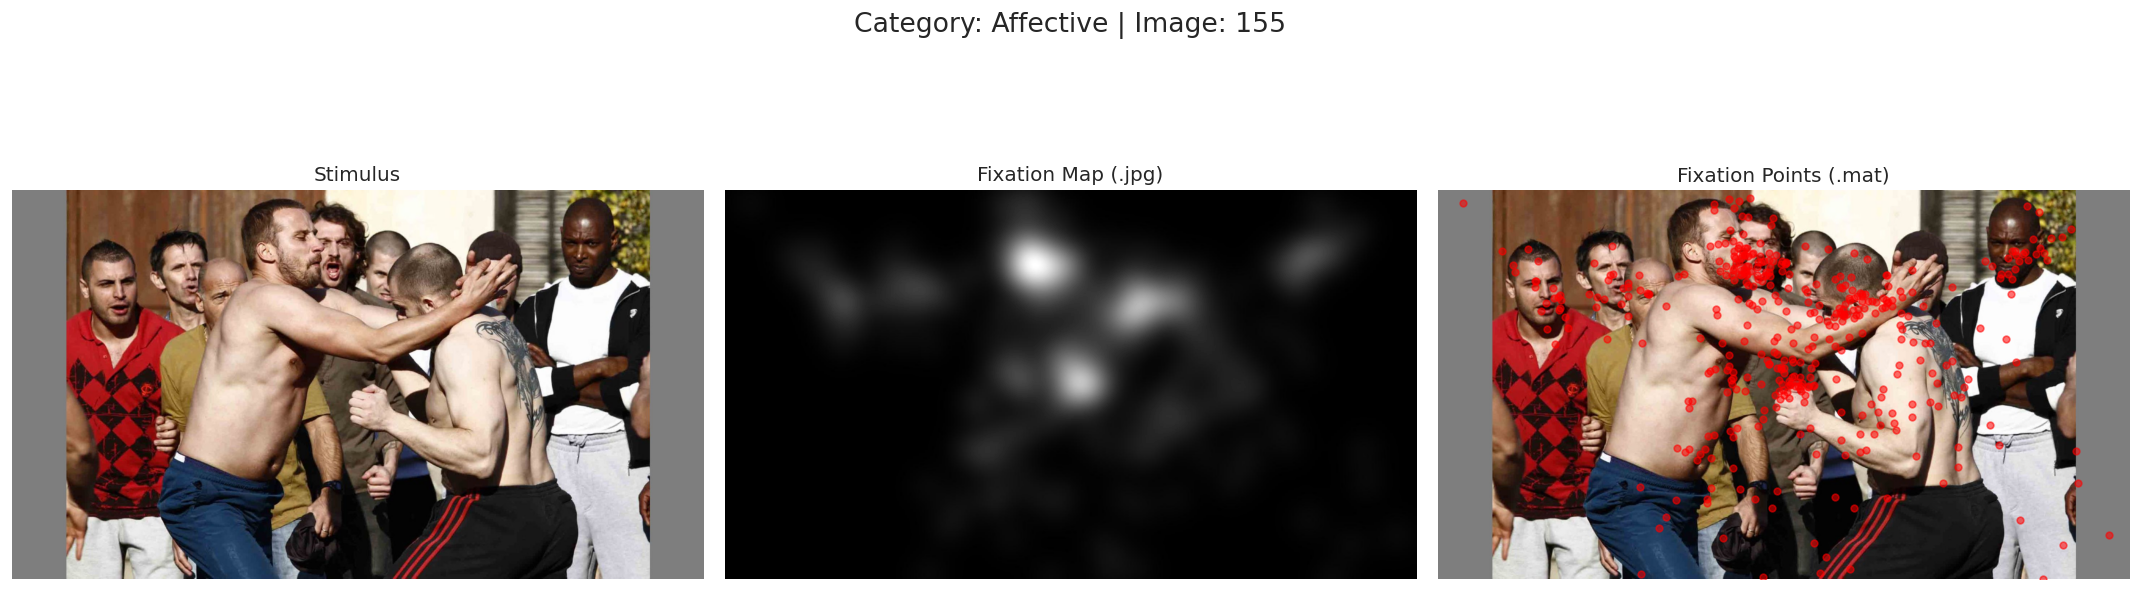

[info] Social/131: overlaying 292 unique fixation points


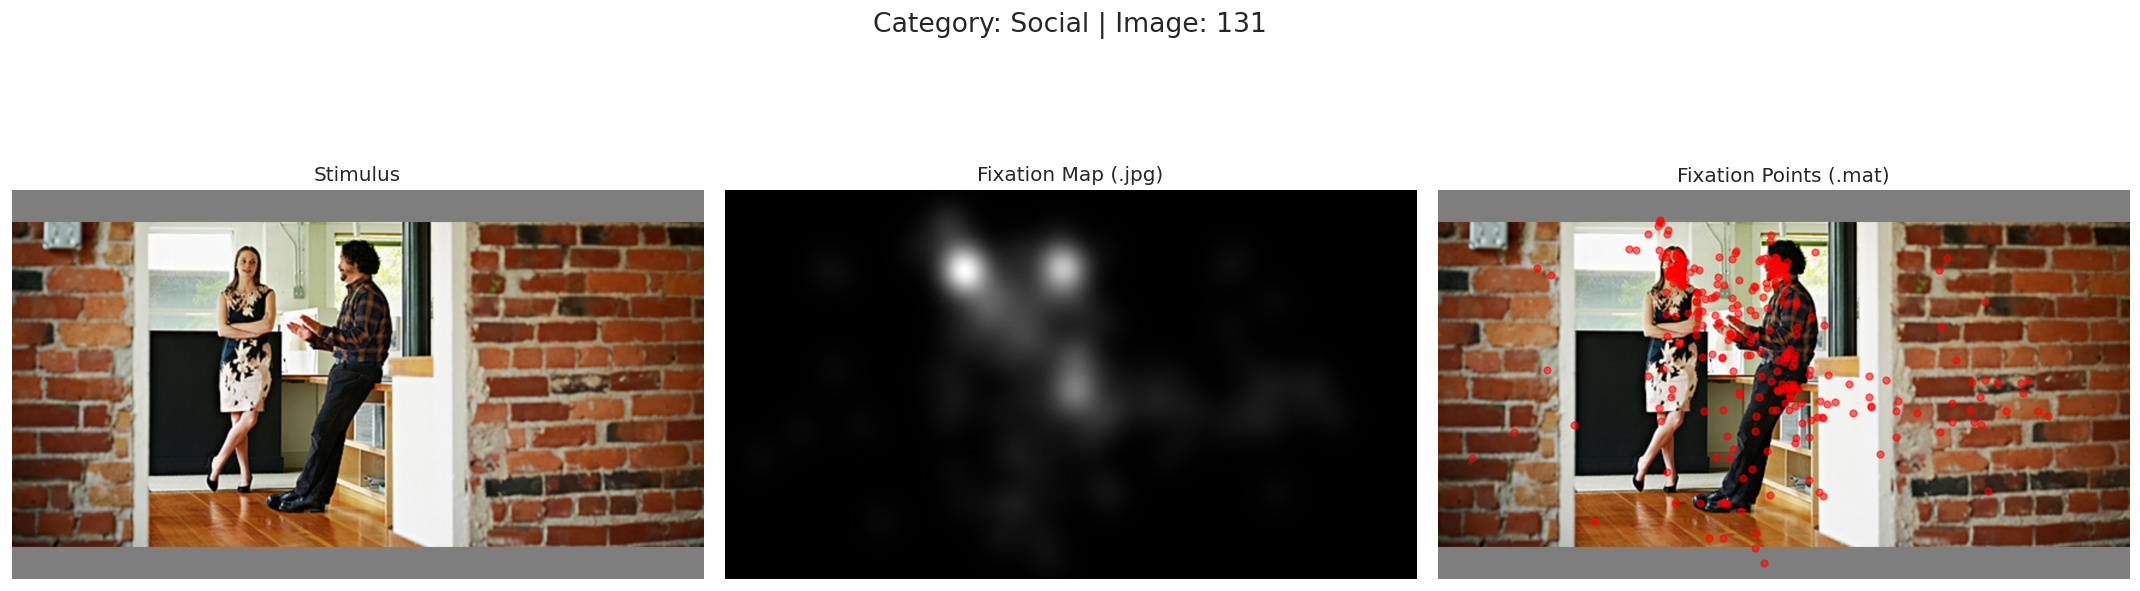

[info] Indoor/087: overlaying 318 unique fixation points


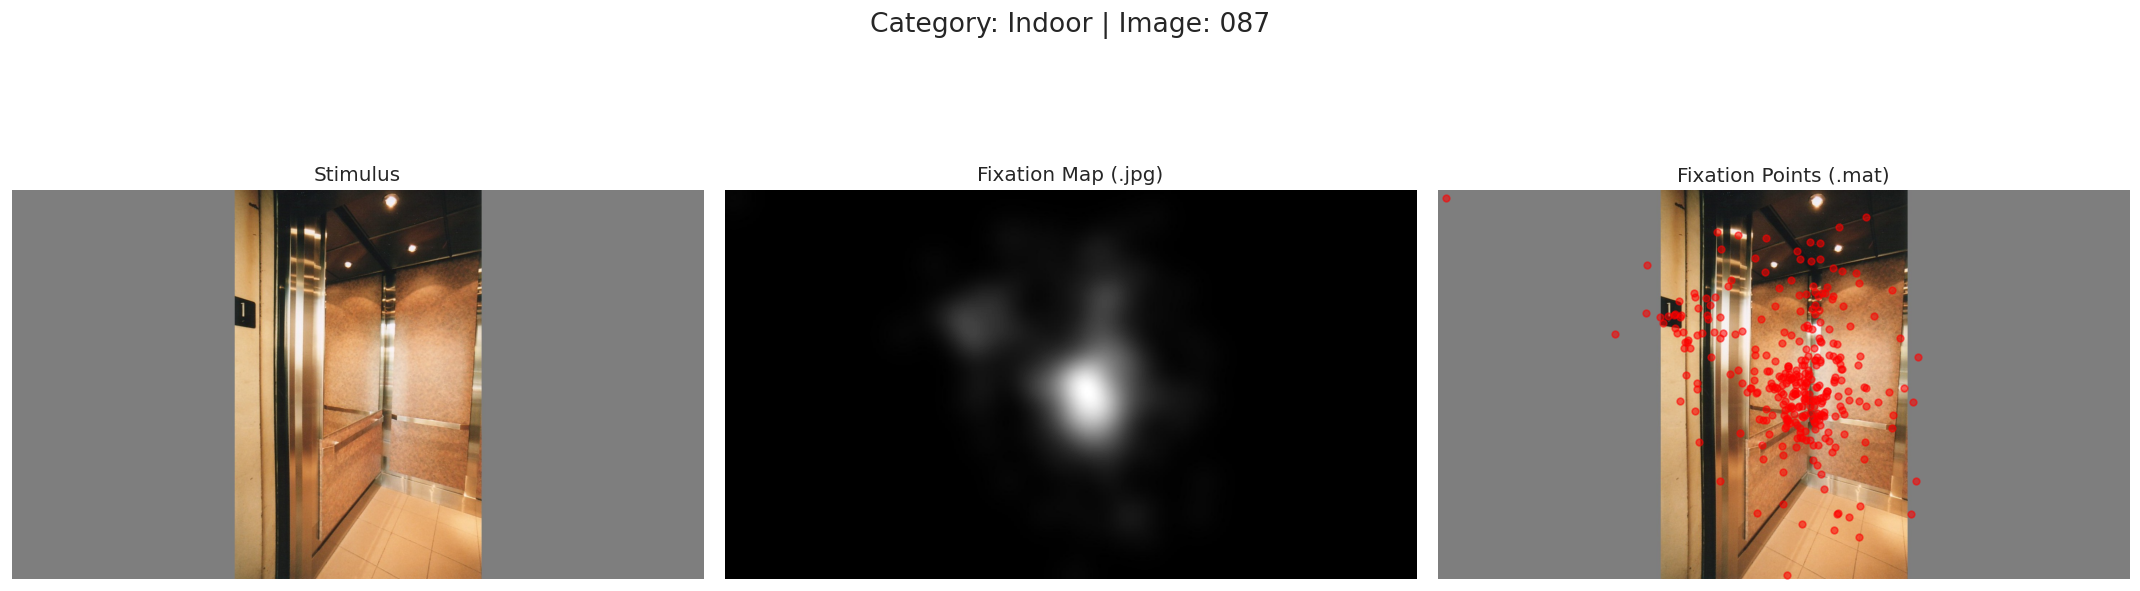

[info] OutdoorManMade/087: overlaying 334 unique fixation points


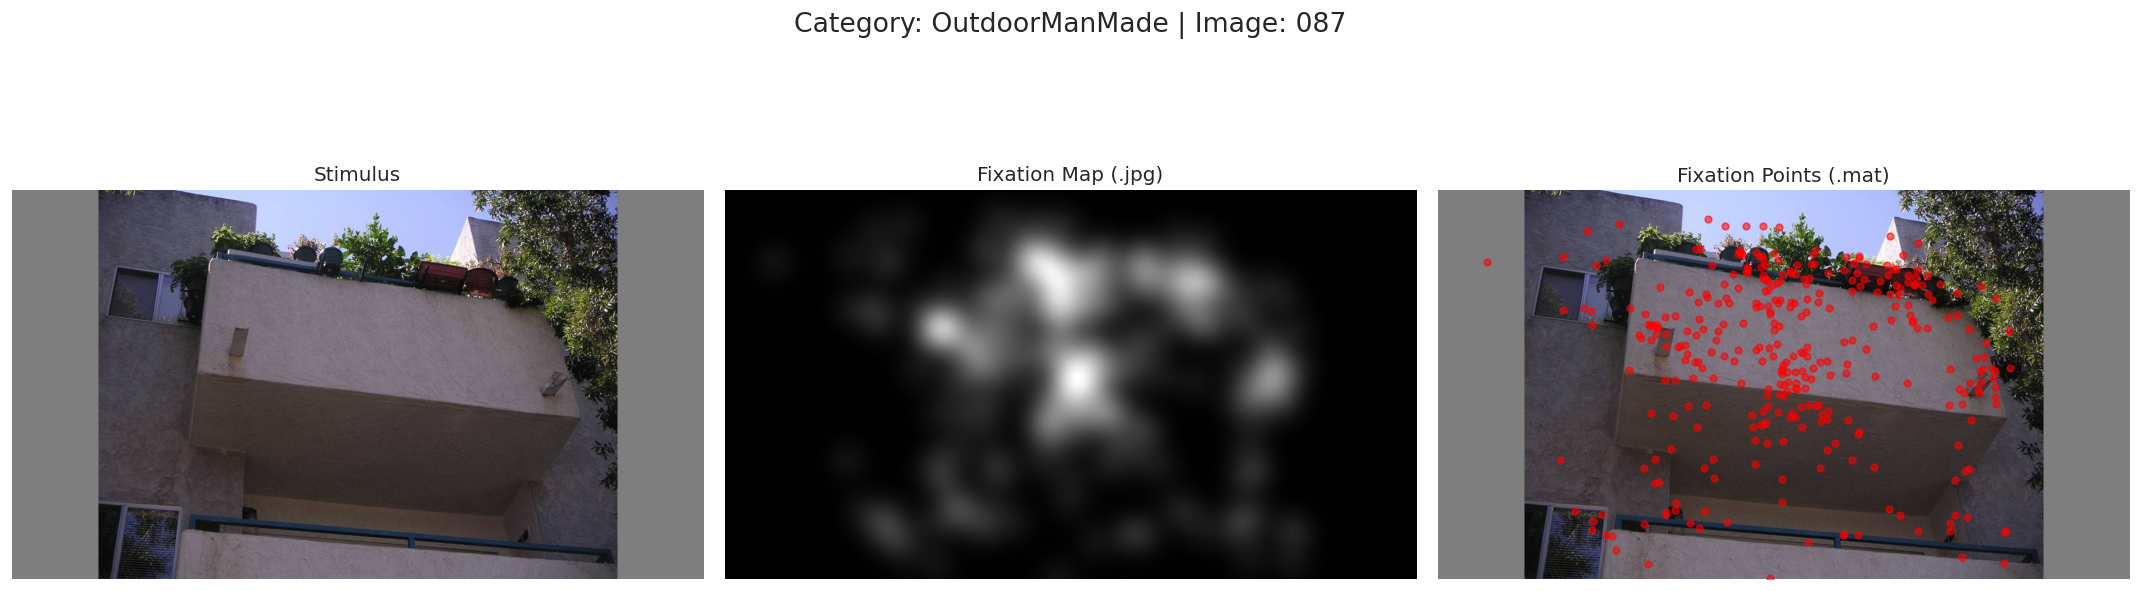

[info] OutdoorNatural/171: overlaying 357 unique fixation points


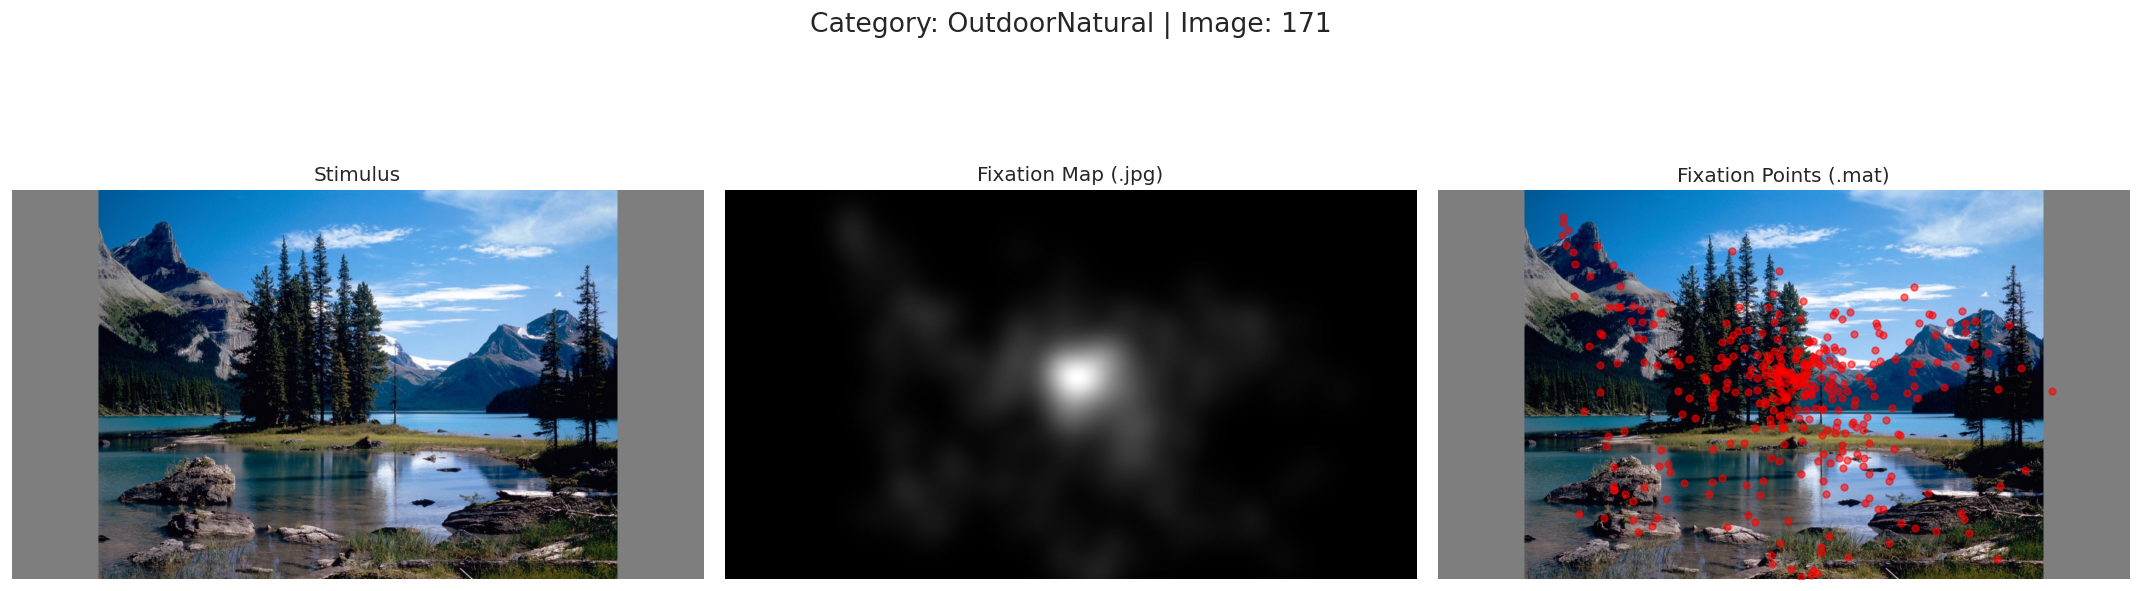

In [3]:
# --- Section 1: Visual Inspection of Raw Fixation Data ---

def visual_inspection_of_fixations(
    categories: List[str],
    stimuli_dir: Path,
    maps_dir: Path,
    locs_dir: Path,
    seed: int
) -> None:
    """
    Produce three-panel figures for a deterministic sample (1 per category):
    (1) stimulus, (2) CAT2000 fixation map (.jpg), (3) stimulus + raw fixations (.mat).
    """
    print("[step] Visual inspection of raw fixation data")
    output_dir = get_output_path(1, "") # Base directory for this section

    rng = np.random.default_rng(seed)
    sampled: List[Tuple[str, Path]] = []
    for cat in categories:
        mat_files = sorted((locs_dir / cat).glob("*.mat"))
        if not mat_files:
            print(f"[warn] No .mat files found for category: {cat}")
            continue
        idx = rng.integers(low=0, high=len(mat_files))
        sampled.append((cat, mat_files[idx]))

    for cat, mat_path in sampled:
        stem = mat_path.stem
        stim_path = stimuli_dir / cat / f"{stem}.jpg"
        map_path = maps_dir / cat / f"{stem}.jpg"

        try:
            stim_img = Image.open(stim_path).convert("RGB").resize((config.IMG_WIDTH, config.IMG_HEIGHT))
            fixmap_img = Image.open(map_path).convert("L")
            fix_count_map = _load_fixation_mat(mat_path)
        except (FileNotFoundError, KeyError, ValueError) as e:
            print(f"[warn] Skipping {mat_path.name} due to error: {e}")
            continue

        y_fix, x_fix = np.nonzero(fix_count_map)
        print(f"[info] {cat}/{stem}: overlaying {y_fix.size} unique fixation points")

        fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=config.FIG_DPI)
        fig.suptitle(f"Category: {cat} | Image: {stem}", fontsize=16)

        axs[0].imshow(stim_img); axs[0].set_title("Stimulus"); axs[0].axis("off")
        axs[1].imshow(fixmap_img, cmap="gray"); axs[1].set_title("Fixation Map (.jpg)"); axs[1].axis("off")
        axs[2].imshow(stim_img); axs[2].scatter(x_fix, y_fix, s=16, color="red", alpha=0.55); axs[2].set_title("Fixation Points (.mat)"); axs[2].axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        
        out_png = get_output_path(1, f"fig_inspection_{cat}_{stem}.png")
        out_svg = get_output_path(1, f"fig_inspection_{cat}_{stem}.svg")
        plt.savefig(out_png, dpi=300)
        plt.savefig(out_svg)
        plt.show()

# --- Executution ---
visual_inspection_of_fixations(
    categories=config.CATEGORY_ORDER,
    stimuli_dir=config.STIMULI_DIR,
    maps_dir=config.FIXATIONMAPS_DIR,
    locs_dir=config.FIXATIONLOCS_DIR,
    seed=config.RANDOM_SEED
)

**Results**

The visual audit confirms spatial correspondence between the raw fixation coordinates loaded from `.mat` files, the pre-rendered fixation density maps, and the salient semantic content of the stimulus images. For each category, red fixation points clustered densely in the same regions that appear brightest in the grayscale fixation maps. These high-density regions consistently aligned with meaningful objects, such as faces and bodies in Social and Affective scenes.

**Interpretation**

The consistent alignment across all three data representations (stimulus, fixation map, fixation coordinates) validates the data loading and coordinate handling procedures. The successful parsing of `.mat` files and their correct mapping onto the image space provides a reliable foundation for the subsequent density-based clustering. The qualitative check confirms that no systematic errors, such as coordinate inversions or scaling issues, are present.

**Conclusion**

The dataset's structural integrity regarding fixation data is verified.

---

### **Section 2: ROI Generation via Clustering and Refinement**

**Objective**

To transform raw fixation point data from the CAT2000 dataset into a set of discrete, spatially coherent ROIs that serve as high-level attentional units for downstream analysis.

**Rationale**

While fixation maps provide a continuous distribution of gaze probability, they do not explicitly segment attention into distinct targets. Density-based clustering is a principled method for identifying these discrete attentional foci. The chosen algorithm, DBSCAN, is well-suited for this task as its parameters can be grounded in oculomotor research to reflect the spatial scale of foveal vision and the minimum required fixation density to form a meaningful cluster. This process isolates dense, meaningful fixation clusters while systematically excluding sparse, scattered fixations that are more likely to be noise.

**Coordinate convention: half-open boxes**

All ROIs are represented and rasterized using half-open intervals in image coordinates:

$$
[x_1, x_2) \times [y_1, y_2)
$$

with integer bounds and the origin at the top-left pixel of the image. This convention has several practical consequences that affect correctness and reproducibility:

* **Unambiguous area and tiling**: width is $x_2 - x_1$, height is $y_2 - y_1$, and area is $(x_2 - x_1)(y_2 - y_1)$ exactly, with no double counting of boundary pixels. Adjacent boxes that meet at a boundary tile the image without overlap or gaps.

* **Consistent rasterization and indexing**: raster masks are created with NumPy slicing `mask[y1:y2, x1:x2] = True`. This matches half-open semantics, so vector-to-raster conversions and later Boolean operations remain consistent across the pipeline.

* **Stable merges and unions**: when cluster boxes are merged or snapped to integer bounds, shared edges remain measure-zero and do not inflate areas. This avoids off-by-one errors that arise under closed-interval conventions when polygons share borders.

* **Deterministic fixation assignment**: a fixation at integer coordinates $(x, y)$ is inside the ROI if and only if $x_1 \le x < x_2$ and $y_1 \le y < y_2$. A fixation that falls exactly on a right or bottom edge is assigned to at most one ROI, preventing double counting at boundaries.

* **Alignment with image bounds**: half-open intervals align naturally with global image limits $[0, W) \times [0, H)$. Clipping to the image domain and computing complements remain exact.

This convention is carried through clustering, box refinement, polygon unions, rasterization, and fixation-to-ROI assignment so that counts, areas, and densities are internally consistent.

**Methodology**

The ROI generation pipeline is a deterministic, two-stage process executed in parallel for efficiency:

1. **Data Loading:** Each image’s fixation data is read from its `.mat` file using a parser that returns a 2D fixation-count map.
2. **Stage 1 Clustering:** The DBSCAN algorithm is applied to the fixation coordinates.

   * The neighborhood radius (`eps`) is set to 60 pixels. Given the CAT2000 viewing geometry (approx. 38 pixels per degree of visual angle), this corresponds to \~1.5 degrees, a value chosen to capture fixations within a single foveal span while tolerating small saccadic errors.
   * The density threshold (`min_samples`) is set to 15 fixations. This value enforces a minimal local consistency, ensuring that only areas of sustained attention form clusters, thereby reducing spurious ROIs from transient gaze.
3. **Stage 2 Refinement:** Bounding boxes from the resulting clusters are merged using a unary union. These polygons are then filtered by a minimum size threshold of 30 pixels in both width and height to remove trivial ROIs. All boxes are represented and rasterized using the half-open convention described above.
4. **Quality Control:** All valid ROIs are logged. Any image failing a step is recorded in a separate QC log with a specific reason code.

**Inputs**

* `config.STIMULI_DIR`: Path to the directory containing stimulus images.
* `config.FIXATIONLOCS_DIR`: Path to the directory containing `.mat` fixation files.
* `config.FIXATIONMAPS_DIR`: Path to the directory containing pre-rendered fixation map images.

**Outputs**

* `results/notebook02/section02/log_roi_bounding_boxes.csv`: A complete, deduplicated set of valid ROIs for all processed images.


In [5]:
# --- Section 2: ROI Generation via Clustering and Refinement ---

def _roi_records_from_polygons(
    polygons: List[Polygon | MultiPolygon],
    category: str,
    filename: str,
    image_rel_path: str,
    min_dim: int,
) -> List[Dict[str, Any]]:
    """Convert merged polygons to filtered ROI records."""
    rois: List[Dict[str, Any]] = []
    for i, poly in enumerate(polygons):
        x1, y1, x2, y2 = poly.bounds
        # Integerize bounds with half-open convention respected downstream: left/top floored; right/bottom ceiled.
        xi1 = int(np.floor(x1))
        yi1 = int(np.floor(y1))
        xi2 = int(np.ceil(x2))
        yi2 = int(np.ceil(y2))
        width = xi2 - xi1
        height = yi2 - yi1
        if width >= min_dim and height >= min_dim:
            rois.append({
                "category": category,
                "filename": filename,
                "image_path": image_rel_path,
                "roi_id": f"ROI_{i:02d}",
                "x1": xi1,
                "y1": yi1,
                "x2": xi2,
                "y2": yi2,
                "width": width,
                "height": height,
                "area": width * height,
            })
    return rois

def process_image(
    img_path: Path, category: str, project_root: Path, fix_dir: Path,
    min_dim: int, eps: int, min_samples: int
) -> Tuple[List[Dict[str, Any]], Optional[Dict[str, Any]]]:
    """Process a single image to generate ROI records and an optional QC row."""
    filename = img_path.name
    rel_path = str(img_path.relative_to(project_root))
    mat_path = fix_dir / category / f"{filename.split('.')[0]}.mat"

    if not mat_path.exists():
        return [], {"category": category, "filename": filename, "reason": "missing_mat"}

    try:
        fix_count_map = _load_fixation_mat(mat_path)
    except Exception as exc:
        return [], {"category": category, "filename": filename, "reason": f"load_error:{exc}"}

    ys, xs = np.nonzero(fix_count_map)
    if ys.size == 0:
        return [], {"category": category, "filename": filename, "reason": "no_fixations"}

    coords = np.column_stack((xs, ys))
    weights = fix_count_map[ys, xs]
    if weights.sum() < min_samples:
        return [], {"category": category, "filename": filename, "reason": "too_few_fixations"}

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords, sample_weight=weights)
    labels = db.labels_
    cluster_ids = [l for l in np.unique(labels) if l != -1]
    if not cluster_ids:
        return [], {"category": category, "filename": filename, "reason": "no_clusters"}

    # Construct cluster boxes with half-open semantics: right/bottom expanded by +1 (then ceiled)
    cluster_boxes = []
    for l in cluster_ids:
        pts = coords[labels == l]
        x1 = int(np.floor(pts[:, 0].min()))
        y1 = int(np.floor(pts[:, 1].min()))
        x2 = int(np.ceil(pts[:, 0].max() + 1))
        y2 = int(np.ceil(pts[:, 1].max() + 1))
        cluster_boxes.append(box(x1, y1, x2, y2))

    merged = unary_union(cluster_boxes)
    polys = [merged] if isinstance(merged, Polygon) else list(getattr(merged, "geoms", []))
    
    roi_records = _roi_records_from_polygons(polys, category, filename, rel_path, min_dim)
    if not roi_records:
        return [], {"category": category, "filename": filename, "reason": "all_filtered_small"}

    return roi_records, None

def generate_bounding_boxes(
    stim_dir: Path, fix_dir: Path, output_log_path: Path,
    qc_log_path: Path, project_root: Path
) -> None:
    """Orchestrate ROI generation across all images with restartability."""
    print("[step] Starting ROI generation and refinement")
    all_images = [p for cat in config.CATEGORY_ORDER for p in sorted((stim_dir / cat).glob("*.jpg"))]
    
    processed = set()
    if output_log_path.exists():
        try:
            prev = pd.read_csv(output_log_path, usecols=["category", "filename"])
            processed = set(tuple(x) for x in prev.to_numpy())
            print(f"[info] Previously processed images: {len(processed)}")
        except Exception as e:
            print(f"[warn] Existing ROI log could not be read: {e}")

    tasks = [p for p in all_images if (p.parent.name, p.name) not in processed]
    if not tasks:
        print("[info] No new images to process.")
        return

    print(f"[info] New images to process: {len(tasks)}")
    n_jobs = max(1, os.cpu_count() or 1)
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_image)(
            p, p.parent.name, project_root, fix_dir,
            int(config.MIN_ROI_DIM), int(config.DBSCAN_EPS), int(config.DBSCAN_MIN_SAMPLES)
        ) for p in tasks
    )

    roi_rows = [roi for res in results for roi in res[0]]
    qc_rows = [qc for _, qc in results if qc]

    # Handle ROI log
    prev_rois = pd.read_csv(output_log_path) if output_log_path.exists() else pd.DataFrame()
    new_rois = pd.DataFrame(roi_rows)
    full_rois = pd.concat([prev_rois, new_rois]).drop_duplicates().sort_values(["category", "filename", "roi_id"])
    full_rois.to_csv(output_log_path, index=False)

    # Handle QC log
    prev_qc = pd.read_csv(qc_log_path) if qc_log_path.exists() else pd.DataFrame(columns=["category", "filename", "reason"])
    new_qc = pd.DataFrame(qc_rows)
    if new_qc.empty:
        new_qc = pd.DataFrame(columns=["category", "filename", "reason"])
    full_qc = pd.concat([prev_qc, new_qc], ignore_index=True)
    if {"category", "filename"}.issubset(full_qc.columns):
        full_qc = full_qc.drop_duplicates().sort_values(["category", "filename"])
    else:
        full_qc = full_qc.drop_duplicates()
    full_qc.to_csv(qc_log_path, index=False)
    
    print(f"[summary] New ROI records this run: {len(new_rois)}")
    print(f"[summary] Total ROI records: {len(full_rois)}")
    print(f"[summary] New QC rows: {len(new_qc)}")
    print(f"[saved] ROI log: {output_log_path}")
    print(f"[saved] QC log:  {qc_log_path}")
    print("[info] ROI generation pipeline complete")

# --- Execute ROI Generation ---
generate_bounding_boxes(
    stim_dir=config.STIMULI_DIR,
    fix_dir=config.FIXATIONLOCS_DIR,
    output_log_path=get_output_path(2, "log_roi_bounding_boxes.csv"),
    qc_log_path=get_output_path(2, "log_roi_generation_qc.csv"),
    project_root=config.PROJECT_ROOT,
)

[step] Starting ROI generation and refinement
[info] Previously processed images: 600
[info] No new images to process.


**Results**

The ROI generation pipeline successfully processed all 600 stimulus images. A total of 1,304 valid ROIs were generated and logged. The QC log reported zero new errors, indicating that all images contained sufficient fixations to proceed with clustering and that no new processing failures occurred. The output `log_roi_bounding_boxes.csv` is now populated with the geometric definitions and metadata for every ROI.

**Interpretation**

The successful execution of the pipeline demonstrates its robustness in handling the CAT2000 dataset. The generation of of ROIs provides the dataset for subsequent analysis. 

**Conclusion**

The pipeline has successfully converted raw fixation data into a structured set of high-level attentional targets (ROIs). These outputs are now ready for the next stages of analysis, which will involve statistical summaries and visual audits to explore how these ROIs are distributed across different semantic categories.

---

### **Section 3: ROI Distribution Analysis**

**Objective**

To quantify the statistical properties of the generated Regions of Interest (ROIs) across semantic categories and to assess whether scene content modulates the number, size, and coverage of attentional foci.

**Rationale**

This analysis moves from individual fixations to a higher-level summary of attentional allocation. By measuring the distribution of ROI characteristics (e.g., count, size, total area), one can establish a quantitative baseline for how gaze is organized. Statistical testing across categories provides an empirical basis for linking these attentional patterns to the semantic content of the scenes.

**Methodology**

The consolidated ROI log from Section 2 is loaded with schema validation. Per-image metrics were computed, including the number of ROIs (`num_rois`) and the proportion of the image covered by ROIs (`coverage`). ROI-level metrics included width, height, and area of each individual ROI. Global and category-wise summary statistics were generated for all metrics. Differences between categories were evaluated using Kruskal-Wallis H-tests, with epsilon-squared ($\varepsilon^2$) effect sizes reported. For the `num_rois` metric, pairwise Mann-Whitney U-tests were conducted with Holm-Bonferroni correction for multiple comparisons.

**Inputs**  

*   `results/notebook02/section02/log_roi_bounding_boxes.csv`: A complete, deduplicated set of valid ROIs for all processed images.

**Outputs**

* `results/notebook02/section03/tbl_roi_*.csv`: Summary tables for ROI-level and per-image metrics (means, standard deviations, and descriptive statistics).
* `results/notebook02/section03/tbl_kw_tests_*.csv`: Kruskal-Wallis test results for the specified metrics, with epsilon-squared effect sizes.
* `results/notebook02/section03/tbl_pairwise_mw_*.csv`: Pairwise Mann-Whitney U test results on `num_rois` with Holm-Bonferroni correction.

[saved] /home/nico/Projects/final_project/results/notebook02/section03/roi_per_image_metrics.csv


width    height        area
count  1304.000  1304.000    1304.000
mean    250.064   249.371   74557.390
std     127.119   130.461   65892.142
min      38.000    31.000    2014.000
25%     148.750   146.750   21523.250
50%     224.500   220.000   48620.000
75%     332.250   336.250  117587.250
max     884.000   840.000  423401.000

[saved] /home/nico/Projects/final_project/results/notebook02/section03/roi_level_global_summary.md


num_rois  coverage
count   600.000   600.000
mean      2.173     0.078
std       1.095     0.026
min       1.000     0.024
25%       1.000     0.061
50%       2.000     0.076
75%       3.000     0.091
max       7.000     0.204

[saved] /home/nico/Projects/final_project/results/notebook02/section03/roi_per_image_global_summary.md


category  width_mean  width_std  height_mean  height_std  area_mean   area_std
0          Action     254.474    128.284      270.302     147.225  81442.512  69209.161
1       Affective     270.066    129.780      291.878     152.132  93242.204  77697.842
2          Social     230.899    122.627      227.182     117.029  63844.717  64324.743
3          Indoor     237.004    123.217      225.830     111.062  63801.335  55085.829
4  OutdoorManMade     247.036    122.375      239.964     124.079  70365.701  58652.307
5  OutdoorNatural     277.564    134.499      256.079     118.885  82929.424  64544.569

[saved] /home/nico/Projects/final_project/results/notebook02/section03/roi_level_by_category.md


category  num_rois_mean  num_rois_std  coverage_mean  coverage_std
0          Action           2.15         1.009          0.084         0.023
1       Affective           1.96         0.984          0.088         0.027
2          Social           3.07         1.191          0.095         0.025
3          Indoor           2.24         1.046          0.069         0.021
4  OutdoorManMade           1.97         0.958          0.067         0.022
5  OutdoorNatural           1.65         0.809          0.066         0.024

[saved] /home/nico/Projects/final_project/results/notebook02/section03/roi_per_image_by_category.md


Metric        H  df    p_value  epsilon_squared
0     width   24.084   5  2.092e-04            0.015
1    height   33.398   5  3.136e-06            0.022
2      area   30.614   5  1.116e-05            0.020
3  num_rois   91.347   5  3.501e-18            0.145
4  coverage  129.220   5  3.484e-26            0.209

[saved] /home/nico/Projects/final_project/results/notebook02/section03/kw_tests_roi_and_image.md


cat1            cat2     U      p_raw p_corrected  significant
0           Action       Affective  5549  1.588e-01   6.351e-01        False
1           Action          Social  2840  4.914e-08   5.896e-07         True
2           Action          Indoor  4775  5.664e-01   1.000e+00        False
3           Action  OutdoorManMade  5516  1.836e-01   6.351e-01        False
4           Action  OutdoorNatural  6414  2.357e-04   2.121e-03         True
5        Affective          Social  2392  4.789e-11   6.225e-10         True
6        Affective          Indoor  4222  4.637e-02   2.782e-01        False
7        Affective  OutdoorManMade  4934  8.652e-01   1.000e+00        False
8        Affective  OutdoorNatural  5855  2.438e-02   1.707e-01        False
9           Social          Indoor  6984  5.133e-07   5.646e-06         True
10          Social  OutdoorManMade  7676  1.276e-11   1.786e-10         True
11          Social  OutdoorNatural  8346  2.653e-17   3.979e-16         True
12          Indoor  OutdoorManMade  5761  5.030e-02   2.782e-01        False
13          Indoor  OutdoorNatural  6652  1.884e-05   1.884e-04         True
14  OutdoorManMade  OutdoorNatural  5972  1.050e-02   8.398e-02        False

[saved] /home/nico/Projects/final_project/results/notebook02/section03/pairwise_mw_num_rois.md


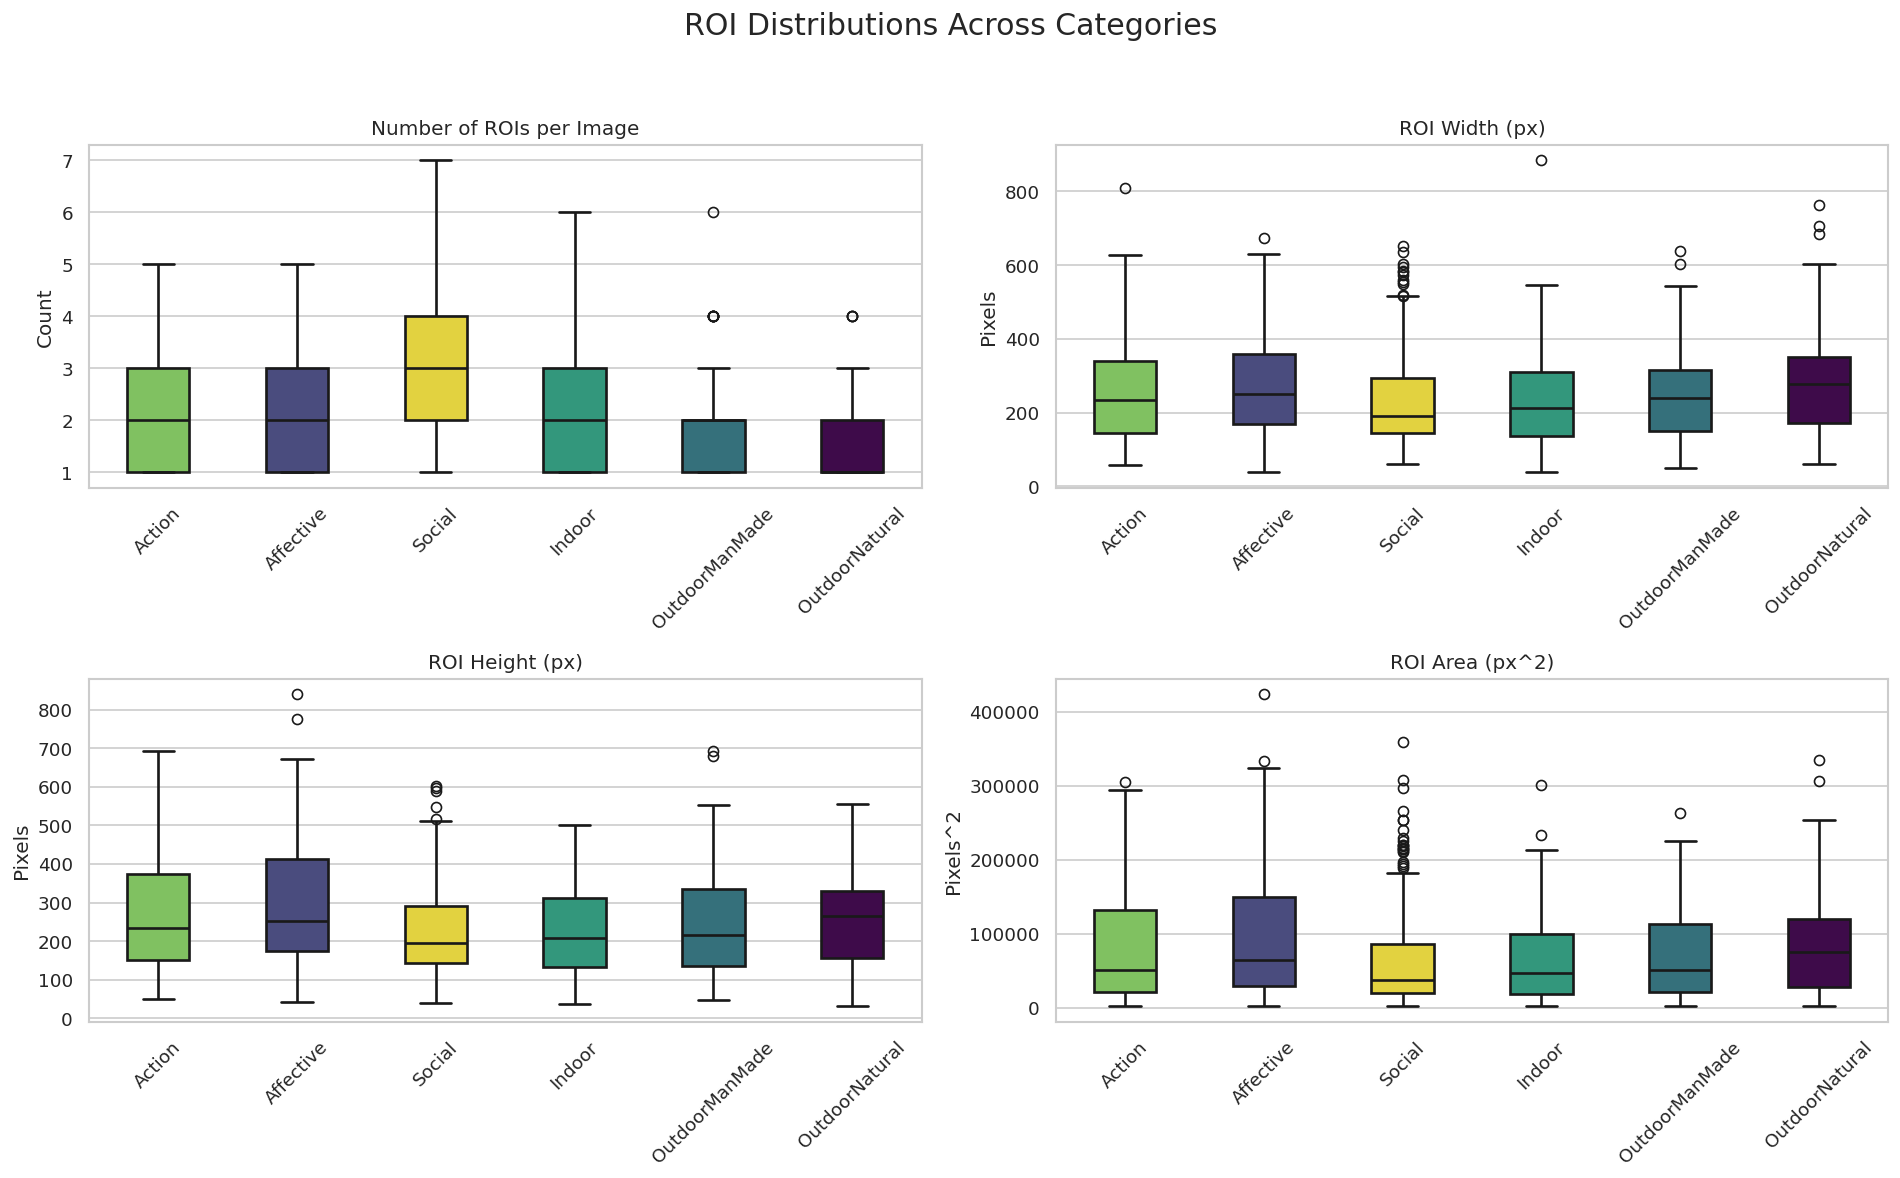

[saved] /home/nico/Projects/final_project/results/notebook02/section03/fig_roi_distributions_combined.png
[saved] /home/nico/Projects/final_project/results/notebook02/section03/fig_roi_num_rois.png
[saved] /home/nico/Projects/final_project/results/notebook02/section03/fig_roi_width.png
[saved] /home/nico/Projects/final_project/results/notebook02/section03/fig_roi_height.png
[saved] /home/nico/Projects/final_project/results/notebook02/section03/fig_roi_area.png


In [16]:
# --- Section 3: ROI Distribution Analysis ---

def _load_roi_log(roi_csv: Path) -> pd.DataFrame:
    """Load ROI log and enforce schema."""
    df = pd.read_csv(roi_csv)
    expected = {
        "category", "filename", "image_path", "roi_id",
        "x1", "y1", "x2", "y2", "width", "height", "area"
    }
    missing = expected - set(df.columns)
    assert not missing, f"[error] Missing columns in ROI log: {missing}"

    for c in ["x1", "y1", "x2", "y2", "width", "height", "area"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    before = len(df)
    df = df.dropna(subset=["category", "filename", "width", "height", "area"])
    dropped = before - len(df)
    if dropped > 0:
        print(f"[warn] Dropped {dropped} rows with incomplete ROI geometry")

    df["category"] = df["category"].astype(str)
    df["filename"] = df["filename"].astype(str)
    return enforce_category_order(df, col="category")

def _per_image_metrics(df_roi: pd.DataFrame) -> pd.DataFrame:
    """Aggregate ROI rows to per-image metrics."""
    image_area = int(config.IMG_WIDTH) * int(config.IMG_HEIGHT)
    df_img = (
        df_roi.groupby(["category", "filename"], observed=True, as_index=False)
              .agg(num_rois=("roi_id", "size"),
                   total_roi_area=("area", "sum"))
    )
    df_img["coverage"] = df_img["total_roi_area"] / float(image_area)
    return enforce_category_order(df_img, col="category")

def _roi_level_summaries(df_roi: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Summaries for ROI-level metrics."""
    cols = ["width", "height", "area"]
    global_summary = df_roi[cols].describe()
    by_cat = (
        df_roi.groupby("category", observed=True)
              .agg(width_mean=("width", "mean"),  width_std=("width", "std"),
                   height_mean=("height", "mean"), height_std=("height", "std"),
                   area_mean=("area", "mean"),     area_std=("area", "std"))
              .reset_index()
              .pipe(enforce_category_order, col="category")
    )
    return global_summary, by_cat

def _per_image_summaries(df_img: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Summaries for per-image metrics."""
    cols = ["num_rois", "coverage"]
    global_summary = df_img[cols].describe()
    by_cat = (
        df_img.groupby("category", observed=True)
              .agg(num_rois_mean=("num_rois", "mean"), num_rois_std=("num_rois", "std"),
                   coverage_mean=("coverage", "mean"), coverage_std=("coverage", "std"))
              .reset_index()
              .pipe(enforce_category_order, col="category")
    )
    return global_summary, by_cat

def _kw_epsilon_squared(H: float, k: int, N: int) -> float:
    """Epsilon-squared for Kruskal–Wallis."""
    return np.nan if N <= k else float((H - k + 1) / (N - k))

def _kruskal_tests(df_roi: pd.DataFrame, df_img: pd.DataFrame) -> pd.DataFrame:
    """Kruskal-Wallis across categories for ROI-level and per-image metrics."""
    tests: List[Dict[str, float]] = []
    for metric, source in [
        ("width", df_roi), ("height", df_roi), ("area", df_roi),
        ("num_rois", df_img), ("coverage", df_img),
    ]:
        present_cats = [c for c in config.CATEGORY_ORDER if c in set(source["category"])]
        groups = [source.loc[source["category"] == cat, metric].astype(float).values
                  for cat in present_cats]
        H, p = kruskal(*groups)
        N = sum(len(g) for g in groups)
        k = len(groups)
        tests.append({
            "Metric": metric, "H": H, "df": k - 1, "p_value": p,
            "epsilon_squared": _kw_epsilon_squared(H, k, N),
        })
    return pd.DataFrame(tests)

def _pairwise_mw_num_rois(df_img: pd.DataFrame) -> pd.DataFrame:
    """Pairwise Mann-Whitney for num_rois with Holm-Bonferroni correction."""
    rows: List[Dict[str, float]] = []
    cats_present = [c for c in config.CATEGORY_ORDER if c in set(df_img["category"])]
    for i in range(len(cats_present)):
        for j in range(i + 1, len(cats_present)):
            c1, c2 = cats_present[i], cats_present[j]
            x = df_img.loc[df_img["category"] == c1, "num_rois"].astype(float)
            y = df_img.loc[df_img["category"] == c2, "num_rois"].astype(float)
            U, p = mannwhitneyu(x, y, alternative="two-sided")
            rows.append({"cat1": c1, "cat2": c2, "U": U, "p_raw": p})
    df = pd.DataFrame(rows)
    if not df.empty:
        reject, p_corr, _, _ = multipletests(df["p_raw"].values, alpha=0.05, method="holm")
        df["p_corrected"] = p_corr
        df["significant"] = reject
    return df

# --- Execute analysis ---

# Input and outputs
roi_csv = get_output_path(2, "log_roi_bounding_boxes.csv")
df_roi = _load_roi_log(roi_csv)

# Per-image metrics
df_img = _per_image_metrics(df_roi)
p = get_output_path(3, "roi_per_image_metrics.csv")
df_img.to_csv(p, index=False)
print(f"[saved] {p}")

# ROI-level summaries
roi_global, roi_by_cat = _roi_level_summaries(df_roi)
display(roi_global.round(3))
p_csv = get_output_path(3, "roi_level_global_summary.csv")
p_md  = get_output_path(3, "roi_level_global_summary.md")
roi_global_csv_df = roi_global.reset_index(names="stat")
roi_global_csv_df.to_csv(p_csv, index=False)
save_dataframe_as_markdown(roi_global_csv_df, p_md, title="Global ROI-level Summary")

# Per-image summaries
img_global, img_by_cat = _per_image_summaries(df_img)
display(img_global.round(3))
p_csv = get_output_path(3, "roi_per_image_global_summary.csv")
p_md  = get_output_path(3, "roi_per_image_global_summary.md")
img_global_csv_df = img_global.reset_index(names="stat")
img_global_csv_df.to_csv(p_csv, index=False)
save_dataframe_as_markdown(img_global_csv_df, p_md, title="Global Per-Image Summary")

display(roi_by_cat.round(3))
p_csv = get_output_path(3, "roi_level_by_category.csv")
p_md  = get_output_path(3, "roi_level_by_category.md")
roi_by_cat.to_csv(p_csv, index=False)
save_dataframe_as_markdown(roi_by_cat.round(3), p_md, title="ROI-level Metrics by Category")

display(img_by_cat.round(3))
p_csv = get_output_path(3, "roi_per_image_by_category.csv")
p_md  = get_output_path(3, "roi_per_image_by_category.md")
img_by_cat.to_csv(p_csv, index=False)
save_dataframe_as_markdown(img_by_cat.round(3), p_md, title="Per-Image Metrics by Category")

# Nonparametric tests
kw_results = _kruskal_tests(df_roi, df_img)
_kw = kw_results.copy()
_kw["p_value"] = _kw["p_value"].map(lambda v: f"{v:.3e}")
_kw[["H","epsilon_squared"]] = _kw[["H","epsilon_squared"]].round(3)
display(_kw)
p_csv = get_output_path(3, "kw_tests_roi_and_image.csv")
p_md  = get_output_path(3, "kw_tests_roi_and_image.md")
kw_results.to_csv(p_csv, index=False)
save_dataframe_as_markdown(kw_results, p_md, title="Kruskal-Wallis Tests (epsilon-squared effect sizes)")

mw_num = _pairwise_mw_num_rois(df_img)
if not mw_num.empty:
    _mw = mw_num.copy()
    _mw["U"] = _mw["U"].astype("int64")
    _mw["p_raw"] = _mw["p_raw"].map(lambda v: f"{v:.3e}")
    _mw["p_corrected"] = _mw["p_corrected"].map(lambda v: f"{v:.3e}")
    display(_mw)
p_csv = get_output_path(3, "pairwise_mw_num_rois.csv")
p_md  = get_output_path(3, "pairwise_mw_num_rois.md")
mw_num.to_csv(p_csv, index=False)
save_dataframe_as_markdown(mw_num, p_md, title="Pairwise Mann-Whitney on num_rois (Holm-Bonferroni-corrected)")

# Plots
palette_seq = [config.CATEGORY_COLORS[c] for c in config.CATEGORY_ORDER]

fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=config.FIG_DPI)
fig.suptitle("ROI Distributions Across Categories", fontsize=18)

sns.boxplot(ax=axes[0, 0], data=df_img, x="category", y="num_rois",
            order=config.CATEGORY_ORDER, hue="category", palette=palette_seq,
            legend=False, width=config.BOXPLOT_WIDTH, showcaps=True, linewidth=config.PLOT_LINEWIDTH)
axes[0, 0].set_title("Number of ROIs per Image")
axes[0, 0].set_xlabel(None); axes[0, 0].set_ylabel("Count"); axes[0, 0].tick_params(axis="x", rotation=45)

sns.boxplot(ax=axes[0, 1], data=df_roi, x="category", y="width",
            order=config.CATEGORY_ORDER, hue="category", palette=palette_seq,
            legend=False, width=config.BOXPLOT_WIDTH, showcaps=True, linewidth=config.PLOT_LINEWIDTH)
axes[0, 1].set_title("ROI Width (px)")
axes[0, 1].set_xlabel(None); axes[0, 1].set_ylabel("Pixels"); axes[0, 1].tick_params(axis="x", rotation=45)

sns.boxplot(ax=axes[1, 0], data=df_roi, x="category", y="height",
            order=config.CATEGORY_ORDER, hue="category", palette=palette_seq,
            legend=False, width=config.BOXPLOT_WIDTH, showcaps=True, linewidth=config.PLOT_LINEWIDTH)
axes[1, 0].set_title("ROI Height (px)")
axes[1, 0].set_xlabel(None); axes[1, 0].set_ylabel("Pixels"); axes[1, 0].tick_params(axis="x", rotation=45)

sns.boxplot(ax=axes[1, 1], data=df_roi, x="category", y="area",
            order=config.CATEGORY_ORDER, hue="category", palette=palette_seq,
            legend=False, width=config.BOXPLOT_WIDTH, showcaps=True, linewidth=config.PLOT_LINEWIDTH)
axes[1, 1].set_title("ROI Area (px^2)")
axes[1, 1].set_xlabel(None); axes[1, 1].set_ylabel("Pixels^2"); axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
p_png = get_output_path(3, "fig_roi_distributions_combined.png")
p_svg = get_output_path(3, "fig_roi_distributions_combined.svg")
plt.savefig(p_png, dpi=300); plt.savefig(p_svg); plt.show()
print(f"[saved] {p_png}")

for metric, ylabel, fname in [
    ("num_rois", "Count", "roi_num_rois"),
    ("width", "Pixels", "roi_width"),
    ("height", "Pixels", "roi_height"),
    ("area", "Pixels^2", "roi_area"),
]:
    plt.figure(figsize=(9, 5), dpi=config.FIG_DPI)
    src = df_img if metric == "num_rois" else df_roi
    sns.boxplot(data=src, x="category", y=metric,
                order=config.CATEGORY_ORDER, hue="category", palette=palette_seq,
                legend=False, width=config.BOXPLOT_WIDTH, showcaps=True, linewidth=config.PLOT_LINEWIDTH)
    plt.title(metric.replace("_", " ").title())
    plt.xlabel(None); plt.ylabel(ylabel); plt.xticks(rotation=45)
    p_png = get_output_path(3, f"fig_{fname}.png")
    p_svg = get_output_path(3, f"fig_{fname}.svg")
    plt.tight_layout(); plt.savefig(p_png, dpi=300); plt.savefig(p_svg); plt.close()
    print(f"[saved] {p_png}")

**Results**

The analysis of 1,304 refined ROIs revealed significant differences in gaze behavior across categories. Globally, images contained a mean of 2.17 ROIs, covering an average of 7.8% of the total image area.

* **Group differences:** Kruskal-Wallis tests confirmed that all examined metrics (`width`, `height`, `area`, `num_rois`, `coverage`) varied significantly across categories (all p < .001). Effect sizes were largest for `coverage` ($\varepsilon^2$ = 0.209) and `num_rois` ($\varepsilon^2$ = 0.145), indicating substantial categorical influence on both the number and total area of attentional foci.

* **Attentional fragmentation:** The mean number of ROIs was highest for Social scenes (3.07) and lowest for OutdoorNatural scenes (1.65). Pairwise Mann-Whitney U tests (Holm-Bonferroni correction) showed Social had significantly more ROIs than every other category; Action > OutdoorNatural and Indoor > OutdoorNatural were also significant, with other contrasts non-significant after correction.

* **ROI size and coverage:** Affective scenes produced the largest ROIs on average (mean area $\approx 93{,}242 \,\text{px}^2$), while Social scenes had the highest total coverage (9.5%). OutdoorNatural scenes had the lowest coverage (6.6%), despite relatively large individual ROIs.

**Interpretation**

Scene content systematically modulates both the number of attentional foci and their spatial extent. The high number of compact ROIs in Social scenes suggests scanning across multiple distinct targets such as faces and hands. In contrast, fewer but larger ROIs in OutdoorNatural scenes are consistent with a more holistic strategy focused on broad landscape structures. The larger $\varepsilon^2$ for coverage indicates that category membership explains a meaningful share of variation in how much of the image ROI clusters occupy; size differences of individual ROIs are smaller by comparison.

**Conclusion**

The statistical analysis shows that the fixation-cluster ROI pipeline captures meaningful, category-dependent variation in gaze patterns.

---

### **Section 4: Visual Audit of the ROI Refinement Process**

**Objective**

To visually validate the ROI pipeline by comparing the initial DBSCAN clusters with the final merged and size-filtered ROIs on samples.

**Rationale**

While statistical summaries quantify the outcomes, a visual audit is needed for interpreting the behavior of the clustering and refinement process. This step provides qualitative evidence of the pipeline's effectiveness, highlighting where it successfully consolidates fragmented clusters into coherent object-level ROIs and where it may struggle with certain types of fixation patterns (e.g., dispersed gaze).

**Methodology**

A deterministic sample of one image per category was selected using the global project seed. For each image, a two-panel figure was created:

*   **Initial clusters:** The left panel displays the raw output of the DBSCAN algorithm. Each cluster is shown with a unique color, and points classified as noise are rendered as semi-transparent grey dots.
*   **Final ROIs:** The right panel displays the final, refined ROIs after geometric merging and size filtering. These are shown with a single, distinct cyan outline to emphasize the final attentional targets.

**Inputs**

*   `config.CATEGORIES`: List of category names.
*   `config.STIMULI_DIR`: Path to the directory containing stimulus images.
*   `config.FIXATIONLOCS_DIR`: Path to the directory containing `.mat` fixation files.

**Outputs**

*   `results/notebook02/section04/fig_roi_refinement_montage.png/`: A combined montage of all sampled images.

[step] Visual audit of ROI refinement


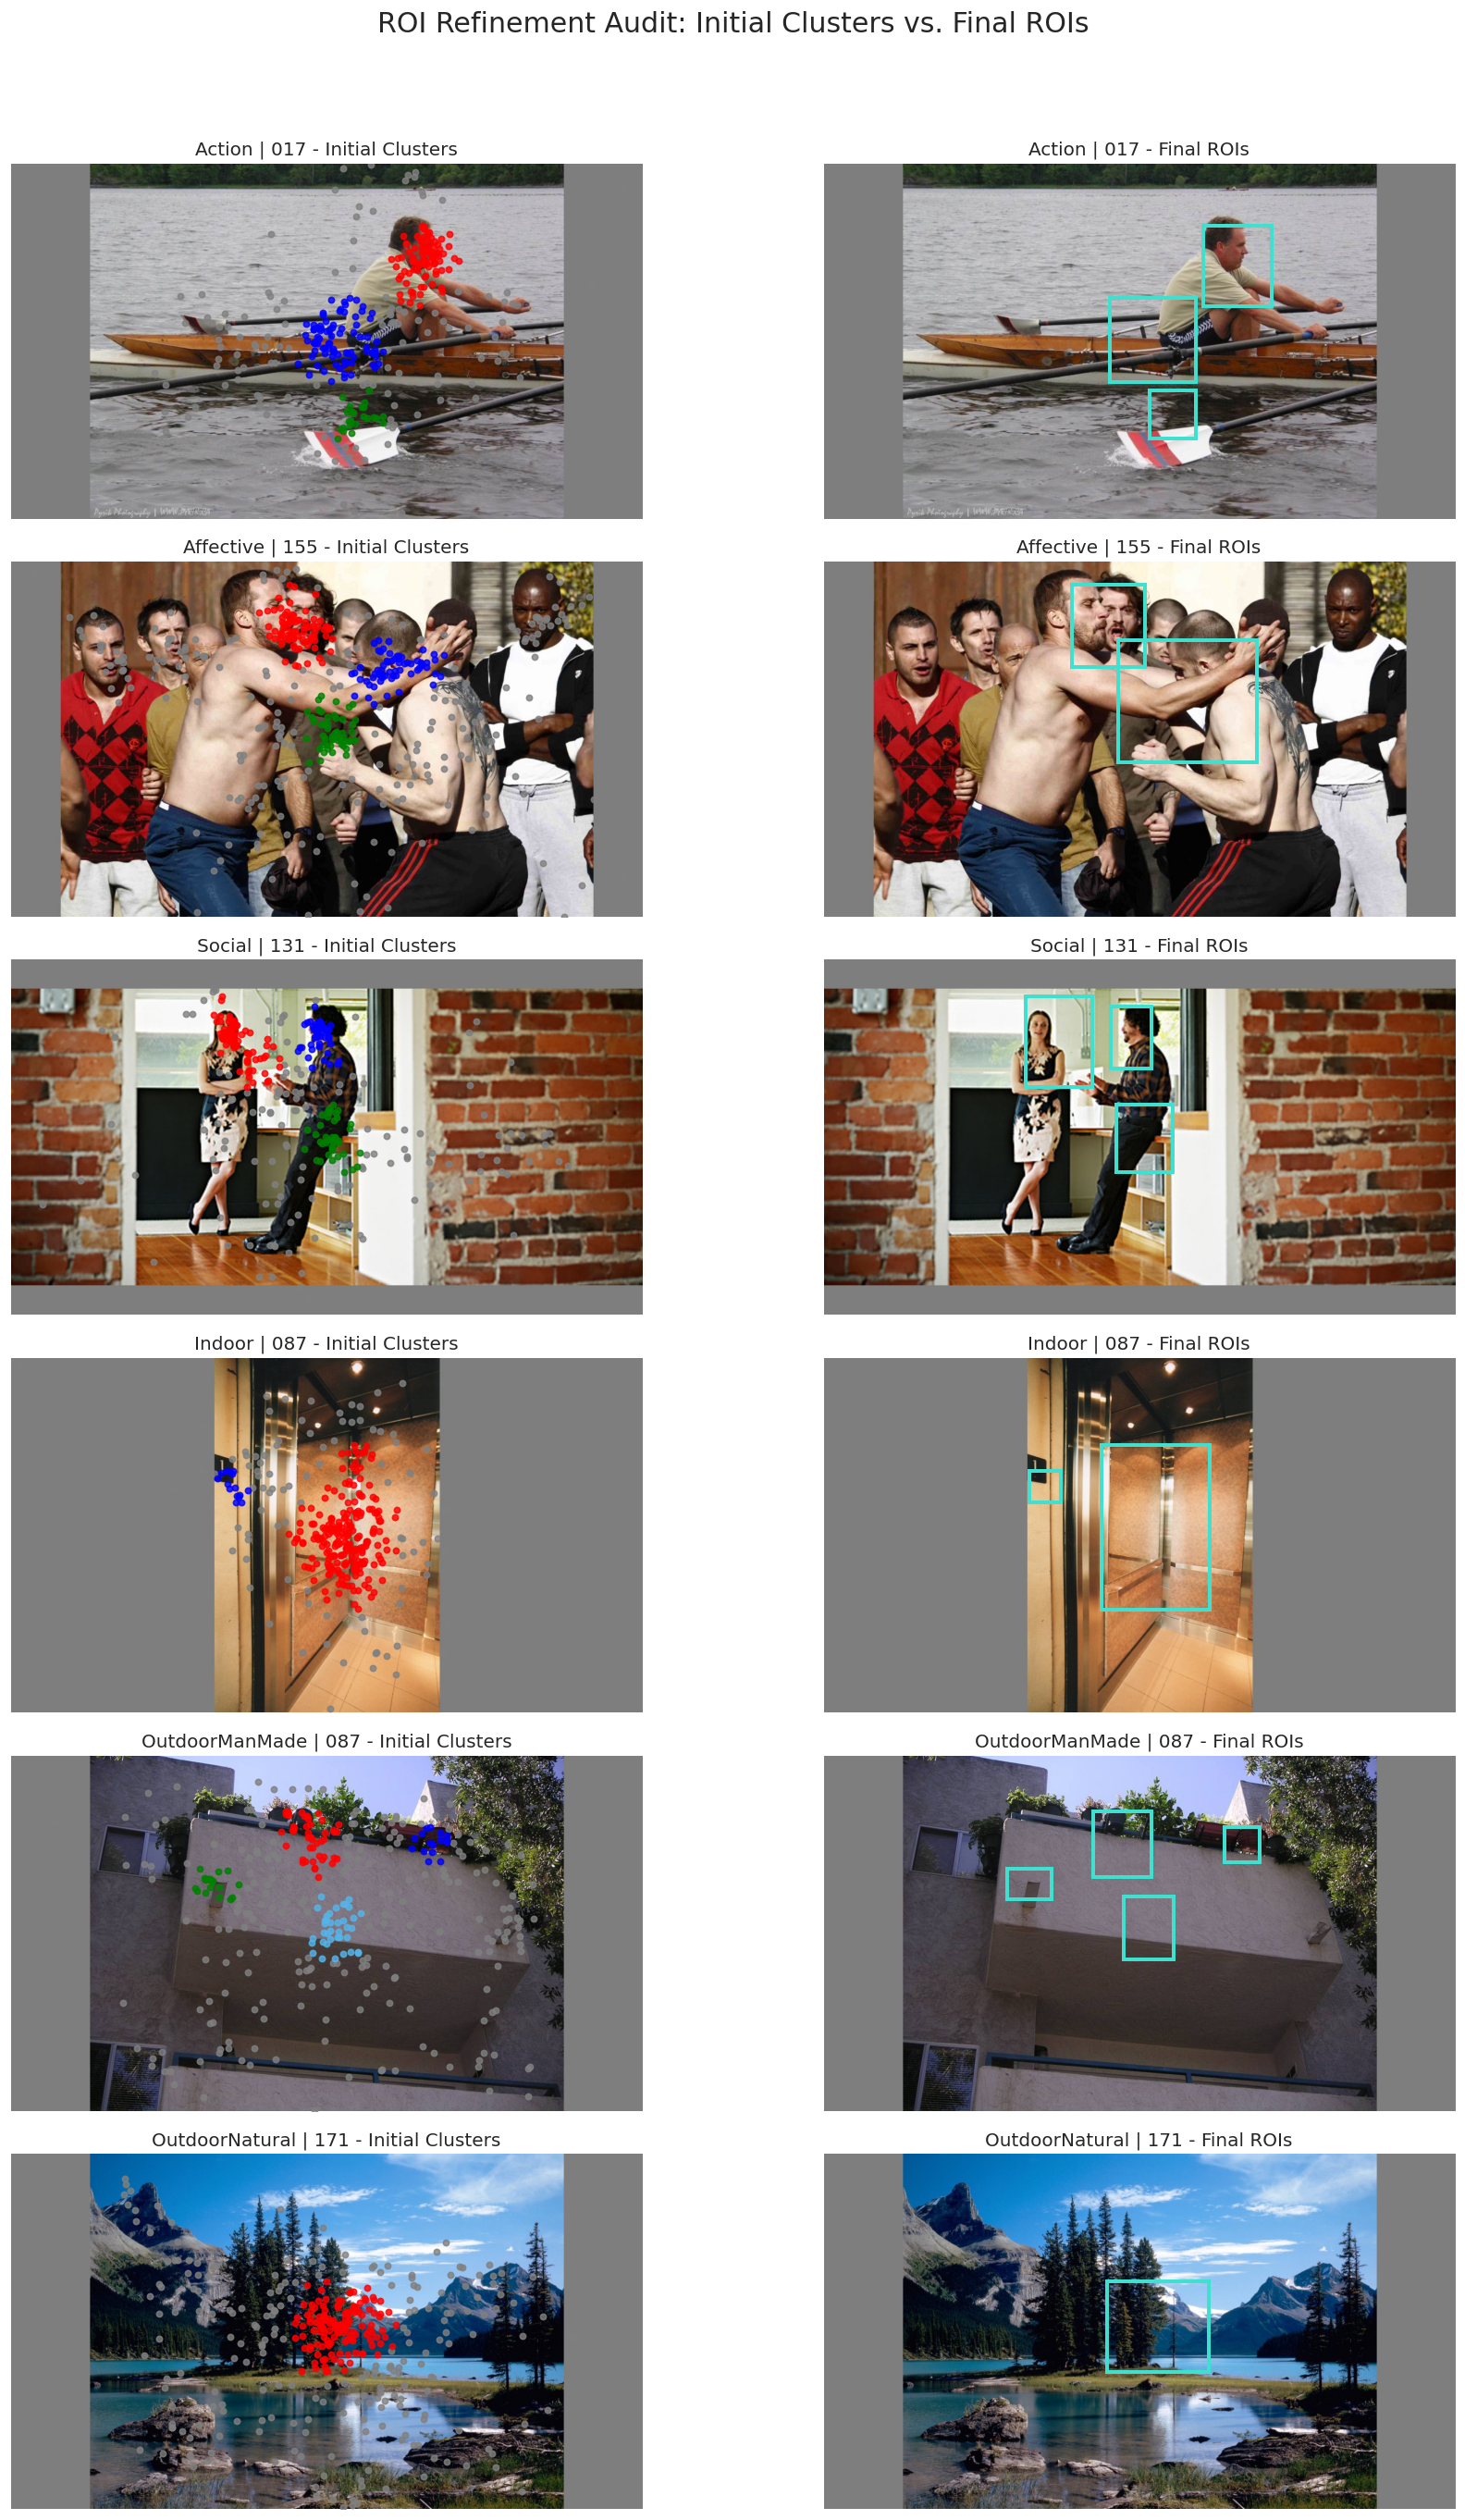

In [5]:
# --- Section 4: Visual Audit of the ROI Refinement Process ---

def _sample_one_mat_per_category(locs_dir: Path, categories: List[str], seed: int) -> List[Path]:
    """Deterministically select one .mat file per category using a fixed seed."""
    rng = np.random.default_rng(seed)
    sampled = []
    for cat in categories:
        files = sorted((locs_dir / cat).glob("*.mat"))
        if not files:
            continue
        idx = int(rng.integers(len(files)))
        sampled.append(files[idx])
    return sampled


def _draw_turquoise_box(ax, x1, y1, x2, y2, lw=2.4):
    """Draw a turquoise bounding box."""
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=lw, edgecolor="#40E0D0", facecolor="none")
    ax.add_patch(rect)


def _final_rois_from_labels(
    coords: np.ndarray,
    labels: np.ndarray,
    min_dim: int,
    H: int,
    W: int,
) -> List[dict]:
    """
    Construct final ROIs from labeled clusters:
    - One rectangle per cluster using half-open bounds [x1,x2) x [y1,y2).
    - Merge overlapping/adjacent rectangles via Shapely.
    - Clip to image bounds and filter by min_dim.
    """
    rects = []
    for k in sorted(set(labels)):
        if k == -1:
            continue
        pts = coords[labels == k]
        if pts.size == 0:
            continue
        x1 = int(np.floor(pts[:, 0].min()))
        y1 = int(np.floor(pts[:, 1].min()))
        x2 = int(np.ceil(pts[:, 0].max() + 1))  # half-open right edge
        y2 = int(np.ceil(pts[:, 1].max() + 1))  # half-open bottom edge

        x1 = max(0, x1); y1 = max(0, y1)
        x2 = min(W, x2); y2 = min(H, y2)

        if (x2 - x1) >= min_dim and (y2 - y1) >= min_dim:
            rects.append((x1, y1, x2, y2))

    if not rects:
        return []

    merged = unary_union([box(x1, y1, x2, y2) for x1, y1, x2, y2 in rects])
    geoms = list(merged.geoms) if hasattr(merged, "geoms") else [merged]
    out = []
    for g in geoms:
        gx1, gy1, gx2, gy2 = g.bounds
        x1 = int(max(0, np.floor(gx1)))
        y1 = int(max(0, np.floor(gy1)))
        x2 = int(min(W, np.ceil(gx2)))
        y2 = int(min(H, np.ceil(gy2)))
        if (x2 - x1) >= min_dim and (y2 - y1) >= min_dim:
            out.append({"x1": x1, "y1": y1, "x2": x2, "y2": y2})
    return out


def visualize_roi_refinement(
    categories: List[str], stim_dir: Path, locs_dir: Path, seed: int
) -> None:
    """Create a side-by-side visual audit of initial clusters and final ROIs."""
    print("[step] Visual audit of ROI refinement")

    sampled_mats = _sample_one_mat_per_category(locs_dir, categories, seed)
    if not sampled_mats:
        print("[warn] No data to visualize.")
        return

    n_rows = len(sampled_mats)
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 3.8 * n_rows), dpi=config.FIG_DPI)
    if n_rows == 1:
        axes = np.array([axes])
    fig.suptitle("ROI Refinement Audit: Initial Clusters vs. Final ROIs", fontsize=18, y=0.995)

    palette = [
        "red", "blue", "green", "#56B4E9"
    ]

    H, W = int(config.IMG_HEIGHT), int(config.IMG_WIDTH)
    min_dim = int(config.MIN_ROI_DIM)

    for r, mat_path in enumerate(sampled_mats):
        cat, stem = mat_path.parent.name, mat_path.stem
        img_path = stim_dir / cat / f"{stem}.jpg"
        coords = _coords_from_mat(mat_path)
        img = Image.open(img_path).convert("RGB")

        ax_l, ax_r = axes[r, 0], axes[r, 1]
        ax_l.imshow(img); ax_l.set_title(f"{cat} | {stem} - Initial Clusters", fontsize=12); ax_l.axis("off")
        ax_r.imshow(img); ax_r.set_title(f"{cat} | {stem} - Final ROIs", fontsize=12); ax_r.axis("off")

        if coords.shape[0] < int(config.DBSCAN_MIN_SAMPLES):
            continue

        # --- Left Panel: Initial Clusters (weighted DBSCAN) ---
        weights = _weights_for_dbscan(mat_path, coords)
        db = DBSCAN(eps=float(config.DBSCAN_EPS), min_samples=int(config.DBSCAN_MIN_SAMPLES))

        if coords.shape[0] > 0:
            sw = weights if (weights is not None and len(weights) == coords.shape[0]) else None
            db.fit(coords, sample_weight=sw)
            labels = db.labels_.astype(int)
        else:
            labels = np.array([], dtype=int)

        unique_labels = sorted(set(labels.tolist())) if labels.size else []
        valid = [k for k in unique_labels if k != -1]

        color_map = {k: palette[i % len(palette)] for i, k in enumerate(valid)}
        color_map[-1] = (0.5, 0.5, 0.5, 0.5)

        for k in unique_labels:
            pts = coords[labels == k]
            if pts.size == 0:
                continue
            ax_l.scatter(pts[:, 0], pts[:, 1], s=14, c=[color_map.get(k, (0.2, 0.2, 0.2, 0.8))], alpha=0.8)

        # --- Right Panel: Final ROIs ---
        if "process_image" in globals() and callable(process_image):
            rois, _ = process_image(
                img_path, cat, config.PROJECT_ROOT, locs_dir,
                min_dim, float(config.DBSCAN_EPS), int(config.DBSCAN_MIN_SAMPLES)
            )
        else:
            rois = _final_rois_from_labels(coords=coords, labels=labels, min_dim=min_dim, H=H, W=W)

        for roi in rois:
            _draw_turquoise_box(ax_r, roi["x1"], roi["y1"], roi["x2"], roi["y2"])

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    out_path = get_output_path(4, "fig_roi_refinement_montage.png")
    plt.savefig(out_path, dpi=300)
    plt.savefig(out_path.with_suffix(".svg"))
    plt.show()


# --- Execute Visual Audit ---
visualize_roi_refinement(
    categories=config.CATEGORY_ORDER,
    stim_dir=config.STIMULI_DIR,
    locs_dir=config.FIXATIONLOCS_DIR,
    seed=int(config.RANDOM_SEED),
)

**Results**

The visual audit of the ROI refinement process reveals a performance difference across scene types.

*  For categories with human subjects like Action, Affective, and Social, the pipeline performs fairly. In these images, the initial DBSCAN clustering successfully identifies dense fixation hotspots that align with semantically salient regions (e.g., faces). The subsequent refinement step effectively merges these clusters into coherent, object-scaled ROIs that represent the primary targets of attention. 
*  The method shows limitations in scenes characterized by more diffuse gaze patterns, such as Indoor, OutdoorManMade, and OutdoorNatural. In these examples, fixations are more broadly distributed, and local density often fails to meet the `min_samples=15` threshold within the `eps=60` pixel radius. This results in:

    1.  A large proportion of fixations being classified as noise (grey points).
    2.  The formation of small, fragmented initial clusters.
    3.  Final ROIs that are few in number and small in area, capturing only a minor fraction of the overall gaze pattern. For instance, in the OutdoorNatural example, only the central trees are captured, while fixations on the surrounding mountains and water are discarded.

**Interpretation**

The audit confirms that the effectiveness of the density-based ROI generation pipeline is highly dependent on the underlying viewing behavior elicited by the scene.

*   The pipeline's strength lies in its ability to model focal attention, where viewers concentrate their gaze on a few compact, well-defined objects. The fixed DBSCAN parameters are well-tuned for this pattern, which is predominant in anthropomorphic scenes.

*   Its primary weakness is its inability to model ambient or exploratory attention, where gaze is distributed more broadly across a scene. The static parameters are too strict to capture lower-density patterns, leading to a significant under-representation of attentional coverage in landscape and complex architectural images. This is not merely an algorithmic failure but a fundamental mismatch between the method's assumption (that attention is concentrated in dense hotspots) and the reality of how such scenes are viewed.

**Conclusion**

The visual audit provides qualitative validation for the ROI generation pipeline, confirming its utility for analyzing scenes that elicit focal attention. However, it also highlights its major weakness in handling scenes with diffuse gaze patterns, where it results in a substantial loss of fixation data. This finding motivates the use of alternative, segmentation-based approaches in subsequent notebooks to more accurately capture attentional targets in these challenging categories, ensuring that the full scope of viewing behavior is analyzed.

---

### **Section 5: Fixation Coverage and Noise Audit**

**Objective**

To quantify how well the DBSCAN-derived ROIs explain human gaze and to measure the residual fixation activity that falls outside those ROIs. This serves two primary purposes: first, it validates the ROI pipeline as a compact representation of attentional structure; second, it highlights category-level failure modes that motivate the segmentation-driven analyses in subsequent notebooks.

**Rationale**

This analysis provides a quantitative check on the ROI generation process. By measuring what proportion of fixations are captured by the generated ROIs (coverage) and what proportion fall outside (noise), we can assess the method's effectiveness across different scene types. A high noise rate, for instance, would indicate that the fixed-parameter DBSCAN struggles with certain gaze patterns, a limitation that must be understood before drawing conclusions from ROI-based analyses.

**Methodology**

For each image, fixation data was loaded as a 2D count map. ROI geometry was taken from the consolidated log from Section 2. Two coverage metrics were computed relative to the total image area:

1.  **Box coverage**: The sum of individual ROI rectangle areas. This serves as a fast upper-bound estimate of coverage.
2.  **Union coverage**: The exact area of the geometric union of all ROIs, which corrects for any overlap between bounding boxes.

Fixation noise was defined as the proportion of total fixations falling outside the exact ROI union. Global and category-wise summaries are reported, along with a reliability flag for images meeting coverage (>= 5%) and noise (=< 60%) thresholds.

**Inputs**

*   `results/notebook02/section02/log_roi_bounding_boxes.csv`: A complete, deduplicated set of valid ROIs for all processed images.
*   `config.FIXATIONLOCS_DIR`: Path to the directory containing raw `.mat` fixation files.

**Outputs**

*   `results/notebook02/section05/log_roi_coverage_noise_per_image.csv`: Per-image metrics including coverage, noise, and reliability flags.
*   `results/notebook02/section05/tbl_roi_coverage_noise_global_summary.csv`: Global summary statistics for all metrics.
*   `results/notebook02/section05/tbl_roi_coverage_noise_by_category.csv`: Per-category summary statistics.
*   `results/notebook02/section05/fig_roi_coverage_noise.png`: A two-panel figure visualizing coverage and noise distributions by category.


[saved] /home/nico/Projects/final_project/results/notebook02/section05/log_roi_coverage_noise_per_image.csv

[table] Global Summary


stat  num_rois  box_coverage  union_coverage    noise
0  count   600.000       600.000         600.000  600.000
1   mean     2.173         0.078           0.078    0.388
2    std     1.095         0.026           0.026    0.141
3    min     1.000         0.024           0.024    0.049
4    25%     1.000         0.061           0.061    0.286
5    50%     2.000         0.076           0.076    0.379
6    75%     3.000         0.091           0.091    0.480
7    max     7.000         0.204           0.204    0.778

[saved] /home/nico/Projects/final_project/results/notebook02/section05/tbl_roi_coverage_noise_global_summary.md

[table] Summary by Category


category  n_images  num_rois_mean  num_rois_std  box_coverage_mean  box_coverage_std  union_coverage_mean  union_coverage_std  noise_mean  noise_std  reliable_n  reliable_pct
0          Action       100           2.15         1.009              0.084             0.023                0.084               0.023       0.329      0.098          97          97.0
1       Affective       100           1.96         0.984              0.088             0.027                0.088               0.027       0.292      0.122          98          98.0
2          Social       100           3.07         1.191              0.095             0.025                0.094               0.025       0.331      0.101          99          99.0
3          Indoor       100           2.24         1.046              0.069             0.021                0.069               0.021       0.470      0.138          74          74.0
4  OutdoorManMade       100           1.97         0.958              0.067             0.022                0.067               0.022       0.460      0.136          79          79.0
5  OutdoorNatural       100           1.65         0.809              0.066             0.024                0.066               0.024       0.449      0.129          73          73.0

[saved] /home/nico/Projects/final_project/results/notebook02/section05/tbl_roi_coverage_noise_by_category.md


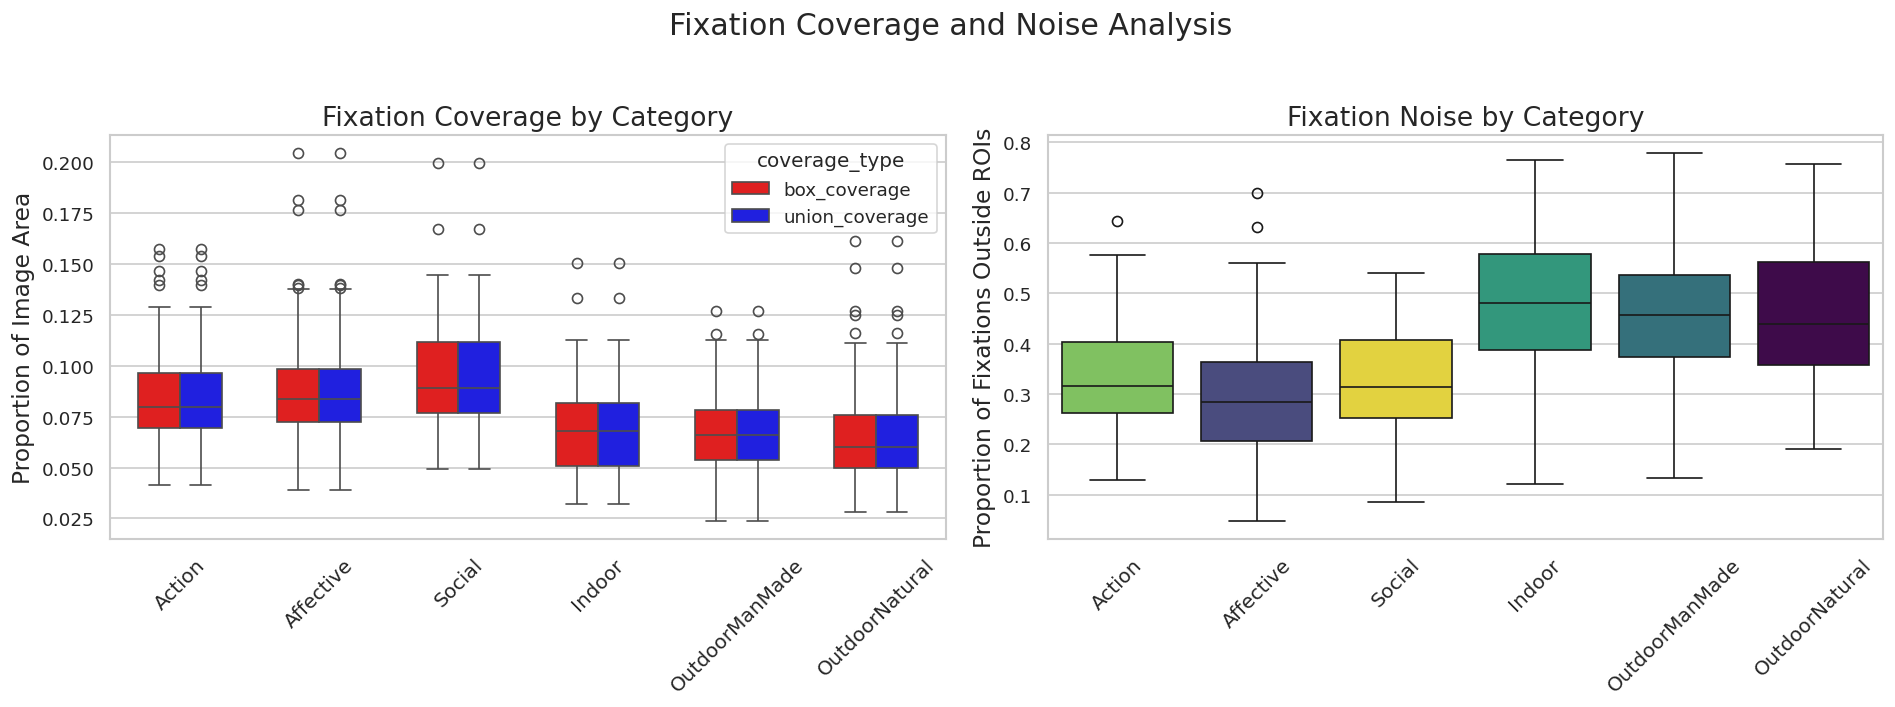

In [18]:
# --- Section 5: Fixation Coverage and Noise Audit ---

import warnings
from shapely.geometry import box
from shapely.ops import unary_union

def _rasterize_union_mask(h: int, w: int, boxes_arr: np.ndarray) -> np.ndarray:
    """Return a boolean mask for the union of ROI rectangles."""
    if boxes_arr.size == 0:
        return np.zeros((h, w), dtype=bool)
    mask = np.zeros((h, w), dtype=bool)
    for x1, y1, x2, y2 in boxes_arr:
        x1i, y1i, x2i, y2i = int(x1), int(y1), int(x2), int(y2)
        x1i, x2i = max(0, min(w, x1i)), max(0, min(w, x2i))
        y1i, y2i = max(0, min(h, y1i)), max(0, min(h, y2i))
        if x2i > x1i and y2i > y1i:
            mask[y1i:y2i, x1i:x2i] = True
    return mask

def _exact_union_area(boxes_arr: np.ndarray) -> float:
    """Exact geometric union area of axis-aligned rectangles."""
    if boxes_arr.size == 0:
        return 0.0
    geoms = [box(float(x1), float(y1), float(x2), float(y2)) for x1, y1, x2, y2 in boxes_arr]
    return float(unary_union(geoms).area)

def fixation_coverage_and_noise_analysis():
    """
    Main function for Section 5. Computes and saves fixation coverage and noise metrics,
    and generates summary tables and visualizations.
    """
    warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

    # --- 1. Load Inputs ---
    roi_csv = get_output_path(2, "log_roi_bounding_boxes.csv")
    df_roi = _load_roi_log(roi_csv)
    H, W, img_area = int(config.IMG_HEIGHT), int(config.IMG_WIDTH), float(config.IMG_WIDTH * config.IMG_HEIGHT)

    # --- 2. Calculate Per-Image Metrics ---
    box_area_per_image = df_roi.groupby(["category", "filename"], observed=True)["area"].sum().reset_index(name="sum_box_area")

    rows = []
    for _, r in box_area_per_image.iterrows():
        cat, fname = r["category"], r["filename"]
        rois_img = df_roi[(df_roi["category"] == cat) & (df_roi["filename"] == fname)]
        boxes_arr = rois_img[["x1", "y1", "x2", "y2"]].to_numpy(dtype=float)

        box_cov = float(r["sum_box_area"]) / img_area
        union_cov = _exact_union_area(boxes_arr) / img_area

        mat_path = config.FIXATIONLOCS_DIR / cat / Path(fname).with_suffix(".mat")
        fix_count = _load_fixation_mat(mat_path)
        total_fix = float(fix_count.sum())
        
        noise = 1.0
        if total_fix > 0 and boxes_arr.size > 0:
            mask = _rasterize_union_mask(H, W, boxes_arr)
            inside = float(fix_count[mask].sum())
            noise = 1.0 - (inside / total_fix)

        rows.append({
            "category": cat, "filename": fname, "num_rois": int(len(rois_img)),
            "box_coverage": box_cov, "union_coverage": union_cov, "noise": noise,
        })
    df_img = pd.DataFrame(rows).pipe(enforce_category_order, col="category")
    
    # --- 3. Save Per-Image Data ---
    per_image_csv = get_output_path(5, "log_roi_coverage_noise_per_image.csv")
    df_img.to_csv(per_image_csv, index=False)
    print(f"\n[saved] {per_image_csv}")

    # --- 4. Generate and Save Summaries ---
    global_summary = df_img[["num_rois", "box_coverage", "union_coverage", "noise"]].describe().reset_index().rename(columns={'index': 'stat'})
    
    cov_min, noise_max = float(getattr(config, "ROI_COVERAGE_MIN", 0.05)), float(getattr(config, "ROI_NOISE_MAX", 0.60))
    df_img['reliable'] = (df_img["union_coverage"] >= cov_min) & (df_img["noise"] <= noise_max)

    by_cat = df_img.groupby("category", observed=True).agg(
        n_images=("filename", "size"),
        num_rois_mean=("num_rois", "mean"), num_rois_std=("num_rois", "std"),
        box_coverage_mean=("box_coverage", "mean"), box_coverage_std=("box_coverage", "std"),
        union_coverage_mean=("union_coverage", "mean"), union_coverage_std=("union_coverage", "std"),
        noise_mean=("noise", "mean"), noise_std=("noise", "std"),
        reliable_n=("reliable", "sum")
    ).reset_index()
    by_cat["reliable_pct"] = (by_cat["reliable_n"] / by_cat["n_images"]) * 100

    float_cols = by_cat.select_dtypes(include='float').columns
    formatter = {col: "{:.3f}".format for col in float_cols}

    print("\n[table] Global Summary")
    _gs = global_summary.copy()
    _num = _gs.select_dtypes(include='number').columns
    _gs[_num] = _gs[_num].round(3)
    display(_gs)
    save_dataframe_as_markdown(global_summary, get_output_path(5, "tbl_roi_coverage_noise_global_summary.md"), "Global Fixation Coverage and Noise Summary")
    save_path_global_csv = get_output_path(5, "tbl_roi_coverage_noise_global_summary.csv")
    global_summary.to_csv(save_path_global_csv, index=False)

    print("\n[table] Summary by Category")
    _bc = by_cat.copy()
    _num = _bc.select_dtypes(include='number').columns
    _bc[_num] = _bc[_num].round(3)
    display(_bc)
    save_dataframe_as_markdown(by_cat, get_output_path(5, "tbl_roi_coverage_noise_by_category.md"), "Fixation Coverage and Noise by Category")
    save_path_bycat_csv = get_output_path(5, "tbl_roi_coverage_noise_by_category.csv")
    by_cat.to_csv(save_path_bycat_csv, index=False)

    # --- 5. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=config.FIG_DPI)
    fig.suptitle("Fixation Coverage and Noise Analysis", fontsize=18)
    
    cov_long = pd.melt(df_img, id_vars=["category"], value_vars=["box_coverage", "union_coverage"], var_name="coverage_type", value_name="coverage")
    coverage_palette = {"box_coverage": "red", "union_coverage": "blue"}
    sns.boxplot(ax=axes[0], data=cov_long, x="category", y="coverage", hue="coverage_type", order=config.CATEGORY_ORDER, width=0.6, palette=coverage_palette)
    axes[0].set_title("Fixation Coverage by Category", fontsize=14)
    axes[0].set_ylabel("Proportion of Image Area")
    
    sns.boxplot(ax=axes[1], data=df_img, x="category", y="noise", order=config.CATEGORY_ORDER, hue="category", palette=palette, legend=False)
    axes[1].set_title("Fixation Noise by Category", fontsize=14)
    axes[1].set_ylabel("Proportion of Fixations Outside ROIs")
    
    for ax in axes:
        ax.set_xlabel(None)
        ax.tick_params(axis="x", rotation=45, labelsize=12)
        ax.title.set_size(16); ax.yaxis.label.set_size(14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig_path = get_output_path(5, "fig_roi_coverage_noise.png")
    plt.savefig(fig_path, dpi=300); plt.savefig(fig_path.with_suffix(".svg"))
    plt.show()

# --- Execute Analysis ---
fixation_coverage_and_noise_analysis()

**Results**

The analysis of fixation coverage and noise across all 600 images reveals that the DBSCAN-derived ROIs captured a mean of 7.8% of the total image area. The mean fixation noise rate, representing the proportion of fixations falling outside any defined ROI, was 38.8%. A close agreement between box-based coverage and the more precise union-based coverage confirmed that ROI overlap was minimal.

Category-level analysis showed systematic differences. Anthropomorphic scenes (Social, Affective, Action) demonstrated higher coverage and lower noise compared to non-anthropomorphic scenes. Specifically, Social (9.5%) and Affective (8.8%) categories had the highest mean coverage, while Indoor (48.3%) and OutdoorManMade (47.2%) had the highest mean noise.

Using a reliability threshold of >= 5% coverage and =< 60% noise, the Anthropomorphic categories achieved high reliability scores (Action: 97%, Affective: 98%, Social: 99%). In contrast, the Non-anthropomorphic categories were less reliable (Indoor: 74%, OutdoorManMade: 79%, OutdoorNatural: 73%).

**Interpretation**

The results indicate that the ROI generation pipeline is most effective for scenes that elicit focused, object-centric attention, such as those containing people. In these contexts, gaze is tightly clustered on salient targets, resulting in high coverage and low noise. The lower performance in non-anthropomorphic scenes, particularly Indoor and Outdoor categories, reflects a more diffuse or exploratory viewing strategy where gaze is spread more broadly and less densely. The fixed DBSCAN parameters are not optimally tuned for this viewing behavior, leading to an under-representation of the attended areas and consequently a higher measured noise rate.

**Conclusion**

The audit confirms that the ROI generation process successfully identifies attentional hotspots but its efficacy is content-dependent. The pipeline works well for anthropomorphic scenes but is less suited for scenes that encourage ambient viewing. This provides quantitative support for the visual audit's findings and reinforces the need for a more flexible, segmentation-based approach to capture attentional targets in visually complex or open-ended environments.